
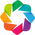

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Setup/import packages
import os 
import glob
import trodes2SS
from trodes2SS import AttrDict, TrodesImport
import sungod_linearization
from sungod_linearization import createTrackGraph, hack_determinearmorder, turn_array_into_ranges, \
chunk_data, change_to_directory_make_if_nonexistent
import numpy as np
import scipy.io
import scipy as sp
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import holoviews as hv
import json
import functools
import dask
import dask.dataframe as dd
import dask.array as da
import networkx as nx
import loren_frank_data_processing as lfdp
import scipy.io as sio # for saving .mat files 
import inspect # for inspecting files (e.g. finding file source)
import multiprocessing 
import sys 
import pickle
from tempfile import TemporaryFile
from multiprocessing import Pool
import math 

path_main = '/home/anna/Src/spykshrk_realtime'
os.chdir(path_main)
from spykshrk.franklab.data_containers import FlatLinearPosition, SpikeFeatures, Posteriors, \
        EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries
from spykshrk.franklab.pp_decoder.util import normal_pdf_int_lookup, gaussian, apply_no_anim_boundary, normal2D
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPEncoder, OfflinePPDecoder
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.util import Groupby

hv.extension('matplotlib')
hv.extension('bokeh')
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)


%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['xtick.labelsize']=20
mpl.rcParams['ytick.labelsize']=20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['axes.titlesize']=26

# this sets the number of displayed rows of a pandas dataframe
pd.options.display.max_rows = 20

In [3]:
#read in start times from trials.mat
path_base_rawdata = '/mnt/vortex/mcoulter/raw_data/'
rat_name = 'remy'
directory_temp = path_base_rawdata + rat_name + '/'
day_dictionary = {'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch_dictionary = {'remy':[2], 'gus':[2], 'bernard':[4], 'fievel':[2]} 
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)

In [5]:
day_dictionary


{'bernard': [23], 'fievel': [19], 'gus': [28], 'remy': [20]}

In [6]:
# this lets us make a list of all positions (or marks) that will become the encoding and decoding subsets
# this is for one interation of the 80/20 split
# now need to figure out how to have it save a different posterior and position file for each of the 5 splits

starttimes[train]
trial_pos_all = pos.head(0)
for i in range(len(starttimes[train])):
    trial_pos = pos.loc[(pos.index.get_level_values('time') <= endtimes[train][i]) & (pos.index.get_level_values('time') >= starttimes[train][i])]
    trial_pos_all = trial_pos_all.append(trial_pos)

trial_pos_all
#pos.head(0)

NameError: name 'train' is not defined

In [66]:
#this generates 5 80/20 splits of the starttimes that are randomized
from itertools import product
from sklearn.model_selection import KFold
import xarray

#for train_trial_id, test_trial_id in KFold(n_spilts=5).split(starttimes):
#	# figure out what data corresponds to training and test trials
#	for position_bandwidth, marks_bandwidth in product(position_bandwidths, marks_bandwidths):
#		fitted_model = encode(training_data, position_bandwidth, marks_bandwidth)
#		cv_score = decode(fitted_model, test_data, true_position)
#		# save the CV score

#KFold(n_spilts=5).split(starttimes)
i = 1
kf = KFold(n_splits=5, shuffle=True)
for train, test in kf.split(starttimes):
    print("%s %s" % (train, test))
    #print("%s %s" % (starttimes[train], starttimes[test]))
    filename = '/mnt/vortex/mcoulter/remy_20_2_crossval_new_' + str(i) + '_mark_stdev_5_posterior.txt'
    train1 = xarray.DataArray(train)
    train1.to_netcdf(filename)
    i = i+1

[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  16  19  20  21
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  48  49  50  51  52  53  54  55  57  58  60  61  64
  67  68  69  70  71  74  75  76  77  78  79  80  82  83  84  85  86  87
  89  90  91  92  93  95  97  98  99 102 103 105 106 107 108] [  9  15  17  18  22  45  47  56  59  62  63  65  66  72  73  81  88  94
  96 100 101 104]
[  1   2   3   7   8   9  11  12  13  14  15  17  18  22  23  24  26  27
  28  29  30  31  32  33  34  35  36  38  40  42  44  45  46  47  48  49
  50  51  52  54  55  56  57  58  59  60  61  62  63  64  65  66  67  69
  70  71  72  73  75  76  77  78  79  80  81  83  84  86  87  88  89  92
  93  94  95  96  97  98  99 100 101 103 104 105 106 107 108] [  0   4   5   6  10  16  19  20  21  25  37  39  41  43  53  68  74  82
  85  90  91 102]
[  0   3   4   5   6   7   8   9  10  11  12  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30 

In [ ]:
# try combining both loops
from itertools import product
from sklearn.model_selection import KFold
import xarray
i = 1
kf = KFold(n_splits=5, shuffle=True)
for encode, decode in kf.split(starttimes):
    print("%s %s" % (encode, decode))
    #print("%s %s" % (starttimes[train], starttimes[test]))
    #filename = '/mnt/vortex/mcoulter/remy_20_2_crossval_new_' + str(i) + '_mark_stdev_5_posterior.txt'
    #train1 = xarray.DataArray(train)
    #train1.to_netcdf(filename)
    
    #encoding position
    encode_trial_pos_all = pos.head(0)
    for i in range(len(starttimes[encode])):
        encode_trial_pos = pos.loc[(pos.index.get_level_values('time') <= endtimes[encode][i]) & (pos.index.get_level_values('time') >= starttimes[encode][i])]
        encode_trial_pos_all = encode_trial_pos_all.append(encode_trial_pos)
    print(encode_trial_pos_all.shape)
    
    #encoding marks
    encode_trial_marks_all = marks.head(0)
    for i in range(len(starttimes[encode])):
        encode_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes[encode][i]) & (marks.index.get_level_values('time') >= starttimes[encode][i])]
        encode_trial_marks_all = encode_trial_marks_all.append(encode_trial_marks)
    print(encode_trial_marks_all.shape)

    #decoding marks
    decode_trial_marks_all = marks.head(0)
    for i in range(len(starttimes[decode])):
        decode_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes[decode][i]) & (marks.index.get_level_values('time') >= starttimes[decode][i])]
        decode_trial_marks_all = decode_trial_marks_all.append(decode_trial_marks)
    print(decode_trial_marks_all.shape)
    
    i = i+1
    

In [ ]:
    posteriors_filtered = posteriors.head(0)
    for i in range(len(starttimes[decode])):
        posteriors_trial = posteriors.loc[(posteriors.index.get_level_values('time') <= endtimes[decode][i]) & (posteriors.index.get_level_values('time') >= starttimes[decode][i])]
        posteriors_filtered = posteriors_filtered.append(posteriors_trial)

In [105]:
#read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])

# randomize trial order
indices = np.arange(starttimes.shape[0])
np.random.shuffle(indices)

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]

#to make a new position, marks and trial file with new start and end times:
#position
encode_trial_pos_all = pos.head(0)
for i in range(len(starttimes_shuffled)):
    encode_trial_pos = pos.loc[(pos.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_trial_pos_all = encode_trial_pos_all.append(encode_trial_pos)
     
#encoding marks
encode_trial_marks_all = marks.head(0)
for i in range(len(starttimes_shuffled)):
    encode_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_trial_marks_all = encode_trial_marks_all.append(encode_trial_marks)


In [110]:
encode_trial_pos_all

<_FlatLinearPosition: None, shape: ((122209, 2))>

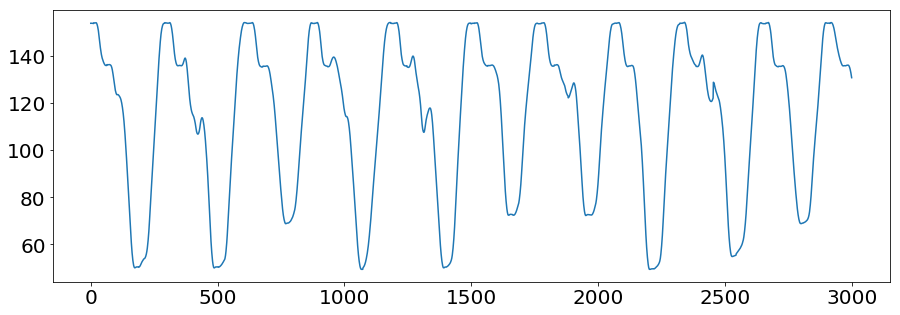

In [146]:
plt.rcParams['figure.figsize'] = [15,5]
encode_trials_vel = encode_trial_pos_all.loc[(encode_trial_pos_all['linvel_flat']>4)]
encode_trials_vel_roll = encode_trials_vel
#encode_trials_vel_roll['linpos_flat'] = np.roll(encode_trials_vel_roll['linpos_flat'],300)
encode_to_plot = encode_trials_vel.reset_index()
#encode_to_plot = encode_trials_vel_roll.reset_index()
encode_to_plot['linpos_flat']
plt.plot(encode_to_plot['linpos_flat'][0:3000])
#encode_trials_vel_roll

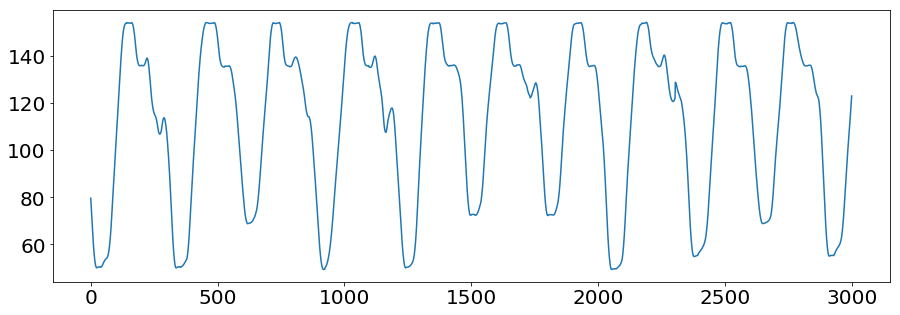

In [148]:
encode_trials_vel = encode_trial_pos_all.loc[(encode_trial_pos_all['linvel_flat']>4)]
encode_trials_vel_roll = encode_trials_vel
encode_trials_vel_roll['linpos_flat'] = np.roll(encode_trials_vel_roll['linpos_flat'],-150)
#encode_to_plot = encode_trials_vel.reset_index()
encode_to_plot = encode_trials_vel_roll.reset_index()
encode_to_plot['linpos_flat']
plt.plot(encode_to_plot['linpos_flat'][0:3000])
#encode_trials_vel_roll

In [79]:
# can we filter out lots of marks for quick
marks_test = trodes2SS.threshold_marks(marks, maxthresh=2000,minthresh=550)
marks_test.shape

0 above 2000uV events removed
3138820 below 550uV events removed


(242777, 4)

In [2]:
# if you want to run the pdb debugger, run this cell
%pdb on

Automatic pdb calling has been turned ON


In [306]:
# Import data

# Define path bases 
path_base_rawdata = '/mnt/vortex/mcoulter/raw_data/'
#path_base_rawdata = '/home/mcoulter/raw_data/'

# Define parameters
rat_name = 'remy'
directory_temp = path_base_rawdata + rat_name + '/'
day_dictionary = {'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch_dictionary = {'remy':[2], 'gus':[2], 'bernard':[2], 'fievel':[2]} 
tetrodes_dictionary = {'remy': [24], # 4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30
                       'gus': [30], # list(range(6,13)) + list(range(17,22)) + list(range(24,28)) + [30]
                        'bernard': [1], 'fievel': [1]}

#remy: [4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30]
#gus: [6,7,8,9,10,11,12,17,18,19,20,21,24,25,26,27,30]
# Maze information
os.chdir('/mnt/vortex/mcoulter/maze_info/' + rat_name)
#maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_NEW')
# new maze coordinates with only one segment for box
maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_one_box')

datasrc = TrodesImport(directory_temp, rat_name, day_dictionary[rat_name], 
                       epoch_dictionary[rat_name], tetrodes_dictionary[rat_name])

# Import marks
marks = datasrc.import_marks()
# # os.chdir('/data2/jguidera/data/')
# # np.load('marks.npy')

# Import position #? concerned about use of sampling rate in the definition for position
# Temporary small definition of encoding settings-- need 'arm_coordinates' to use datasrc.import_pos 
encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# Import position (#? concerned about use of sampling rate in the definition for position)
pos = datasrc.import_pos(encode_settings, xy='x')
posY = datasrc.import_pos(encode_settings, xy='y')

# Import ripples
rips = datasrc.import_rips(pos, velthresh=4) # commented out until I get rips definition working

# Define path bases
path_base_dayepoch = 'day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0])
path_base_analysis = '/mnt/vortex/mcoulter/maze_info/'


duplicates found & removed: 0


In [299]:
pos.loc[(pos["linvel_flat"]>2)]
pos_old_subset

<_FlatLinearPosition: None, shape: ((30001, 2))>

In [260]:
pos_old = pos
pos_oldY = posY

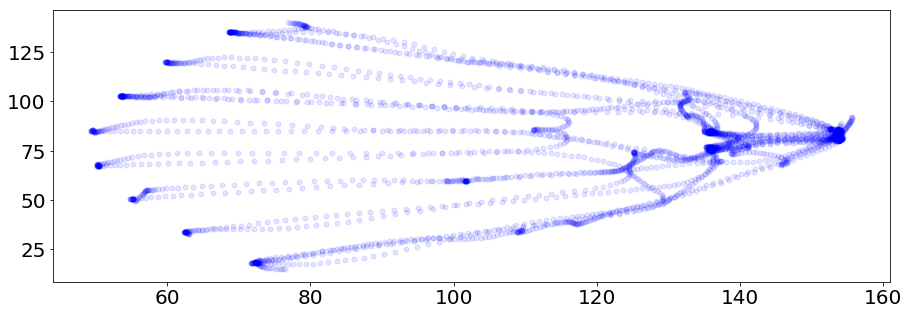

In [321]:
# plot 2D position for new and old pos files
# plot transformation of position from 2D to linear - see what happends to reward well at arm ends
# also see how much position is lost at arm ends when gap between arms is applied
# old time: 1361-2370
plt.rcParams['figure.figsize'] = [15,5]
subset_start = 0
subset_end = 10000
chunkstart = pos_old.index.get_level_values('time')[subset_start]
chunkend = pos_old.index.get_level_values('time')[subset_end]
speed_threshold_save = 0; 

pos_old_subset = pos_old.loc[(pos_old.index.get_level_values('time') <= chunkend) & (pos_old.index.get_level_values('time') >= chunkstart)]
pos_oldY_subset = pos_oldY.loc[(pos_oldY.index.get_level_values('time') <= chunkend) & (pos_oldY.index.get_level_values('time') >= chunkstart)] 
pos_old_start= pos_old_subset.index.get_level_values('time')[0]
pos_old_end = pos_old_subset.index.get_level_values('time')[-1]

old_vel_pos = pos_old_subset.loc[(pos_old_subset["linvel_flat"]>4)]
old_vel_posY = pos_oldY_subset.loc[(pos_oldY_subset["linvel_flat"]>4)]

plt.plot(old_vel_pos['linpos_flat'].values,old_vel_posY['linpos_flat'].values,'b',marker='.',markersize=10,linestyle='',alpha=0.1)
#plt.plot(vel_pos['linpos_flat'].values,vel_posY['linpos_flat'].values,'r',marker='.',markersize=10,linestyle='',alpha=0.1)
#plt.plot(pos_old_subset['linvel_flat'].values[5000:7000])
#plt.plot(pos_subset['linvel_flat'].values[5000:7000])
#plt.ylim(0,10)

(0, 10)

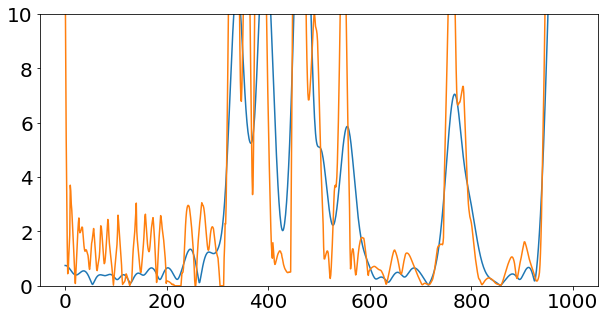

In [292]:
plt.plot(pos_old_subset['linvel_flat'].values[0:1000])
plt.plot(pos_subset['linvel_flat'].values[0:1000])
plt.ylim(0,10)

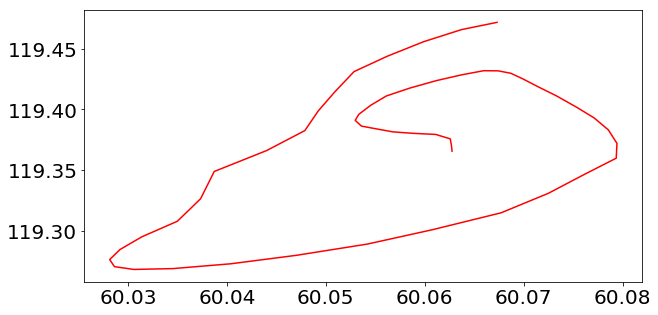

In [355]:
# plot 2D position for new and old pos files
# plot transformation of position from 2D to linear - see what happends to reward well at arm ends
# also see how much position is lost at arm ends when gap between arms is applied
# new
plt.rcParams['figure.figsize'] = [10,5]
subset_start = 120150
subset_end = 120200
chunkstart = pos.index.get_level_values('time')[subset_start]
chunkend = pos.index.get_level_values('time')[subset_end]
speed_threshold_save = 0; 

pos_subset = pos.loc[(pos.index.get_level_values('time') <= chunkend) & (pos.index.get_level_values('time') >= chunkstart)]
posY_subset = posY.loc[(posY.index.get_level_values('time') <= chunkend) & (posY.index.get_level_values('time') >= chunkstart)] 
pos_start= pos_subset.index.get_level_values('time')[0]
pos_end = pos_subset.index.get_level_values('time')[-1]

vel_pos = pos_subset.loc[(pos_subset["linvel_flat"]>4)]
vel_posY = posY_subset.loc[(posY_subset["linvel_flat"]>4)]

plt.plot(pos_subset['linpos_flat'].values,posY_subset['linpos_flat'].values,'r')
#plt.plot(pos_subset['linpos_flat'].values[5000:7000],posY_subset['linpos_flat'].values[5000:7000],'r')
#plt.plot(pos_old_subset['linpos_flat'].values[7900:8107],pos_oldY_subset['linpos_flat'].values[7900:8107],'k', linestyle='dashed')

#plt.plot(pos_subset['linvel_flat'].values)

In [ ]:
#calculate firing rate for each tetrode then do circular shift
marks.xs(29,level='elec_grp_id')
epoch_time
len(marks.xs(26,level='elec_grp_id'))/epoch_time
starttimes_shuffled
tet_id = 30
tetrode_x_firing_rate = []
for i in range(len(starttimes_shuffled)):
    length = len(marks.xs(tet_id,level='elec_grp_id').loc[(marks.xs(tet_id,level='elec_grp_id').index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.xs(tet_id,level='elec_grp_id').index.get_level_values('time') >= starttimes_shuffled[i])])
    tetrode_x_firing_rate.append(length/(endtimes_shuffled[i]-starttimes_shuffled[i]))
len(tetrode_x_firing_rate)
#plt.hist(tetrode_x_firing_rate)
#plt.title('tet 30 marks rate all trials')
#plt.xlabel('marks/sec')
np.median(tetrode_x_firing_rate)

# pull out timestamp and time levels of the multiindex
marks_timestamp = encode_spikes_random_trial.reset_index(level='timestamp')
marks_time = marks_timestamp.reset_index(level='time')

# keep original time and timestamps in new columns
marks_time['timestamp_original'] = marks_time['timestamp']
marks_time['time_original'] = marks_time['time']

marks_time.drop(columns=['timestamp'])

# amount to shift = 5 min + 5 sec = 305 seconds
marks_index_shift = int(305*np.median(tetrode_x_firing_rate))
#marks_shift['time'] = np.roll(random_trial_pos_all_vel_shuffle['time'],-(marks_index_shift))
#marks_time.loc[(marks_time.xs(tet_id,level='elec_grp_id'))]['time']
#marks_time.loc[(marks_time.xs(tet_id,level='elec_grp_id'))]
marks_time
marks_time.xs(tet_id,level='elec_grp_id')['time'] = np.roll(marks_time.xs(tet_id,level='elec_grp_id')['time'],-(marks_index_shift))
marks_time.xs(tet_id,level='elec_grp_id')


In [122]:
#calculate firing rate for all spikes with vel > 4 then do circular shift of spikes
encode_spikes_all = []
linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(marks)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')
encode_spikes_all = marks.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_all

tetrode_x_firing_rate = []
for i in range(len(starttimes_shuffled)):
    length = len(encode_spikes_all.loc[(encode_spikes_all.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_all.index.get_level_values('time') >= starttimes_shuffled[i])])
    tetrode_x_firing_rate.append(length/(endtimes_shuffled[i]-starttimes_shuffled[i]))
len(tetrode_x_firing_rate)
#plt.hist(tetrode_x_firing_rate)
#plt.title('tet 30 marks rate all trials')
#plt.xlabel('marks/sec')
np.median(tetrode_x_firing_rate)
marks_index_shift = int(305*np.median(tetrode_x_firing_rate))

# we can actually just roll each tetrode channel by the calculated number of indices
encode_spikes_all['c00'] = np.roll(encode_spikes_all['c00'],-(marks_index_shift))
encode_spikes_all['c01'] = np.roll(encode_spikes_all['c01'],-(marks_index_shift))
encode_spikes_all['c02'] = np.roll(encode_spikes_all['c02'],-(marks_index_shift))
encode_spikes_all['c03'] = np.roll(encode_spikes_all['c03'],-(marks_index_shift))

encode_spikes_all
#marks_index_shift

<__SpikeFeatures: None, shape: ((1184864, 4))>

In [135]:
#marks_index_target = min_time + 0.25*epoch_time
#encode_spikes_shift_query = encode_spikes_all.reset_index()
#encode_spikes_shift_query[encode_spikes_shift_query['time']==marks_index_target].index
#.index.item()
#encode_spikes_shift_query.iloc[(encode_spikes_shift_query['time']-marks_index_target).abs().argsort()[:1]].index.item()
encode_spikes_random_trial = []
linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(marks)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')
encode_spikes_random_trial = marks.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_random_trial

    # save dataframe with both shifted and original marks
encode_spikes_random_trial_encoder = encode_spikes_random_trial
encode_spikes_random_trial_encoder


encode_spikes_random_trial_save = encode_spikes_random_trial
encode_spikes_random_trial_save['c00_shift'] = np.roll(encode_spikes_random_trial_save['c00'],-(marks_index_shift))
encode_spikes_random_trial_save['c01_shift'] = np.roll(encode_spikes_random_trial_save['c01'],-(marks_index_shift))
encode_spikes_random_trial_save['c02_shift'] = np.roll(encode_spikes_random_trial_save['c02'],-(marks_index_shift))
encode_spikes_random_trial_save['c03_shift'] = np.roll(encode_spikes_random_trial_save['c03'],-(marks_index_shift)) 

encode_spikes_random_trial = []
encode_spikes_random_trial = marks.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_random_trial['c00'] = np.roll(encode_spikes_random_trial['c00'],-(marks_index_shift))
encode_spikes_random_trial['c01'] = np.roll(encode_spikes_random_trial['c01'],-(marks_index_shift))
encode_spikes_random_trial['c02'] = np.roll(encode_spikes_random_trial['c02'],-(marks_index_shift))
encode_spikes_random_trial['c03'] = np.roll(encode_spikes_random_trial['c03'],-(marks_index_shift))  
encode_spikes_random_trial
    # apply shift to tetrode channel columns in original dataframe


<__SpikeFeatures: None, shape: ((1184864, 4))>

In [144]:
marks_flat = marks.reset_index()
marks_flat['time'].iloc[0]
marks_flat['time'].iloc[-1]
marks_flat['time'].iloc[-1] - marks_flat['time'].iloc[0]
5485.4081 - 1361.0241

4124.384

In [255]:
#cell 9.1 randomize trial order within epoch
    #read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])
print('Number of trials: ',trialsindex.shape)


    # randomize trial order
indices = np.arange(starttimes.shape[0])
np.random.shuffle(indices)

    #fixed random order
indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
6,  76,  13,  82,  18,  25,  64,  96,  20,  16,  65,  54,  12,  24,  56,   5,  74,  73, 
79,  89,  97,  70,  68,  46,   7,  40, 101,  48,  77,  63,  69, 108,  66,  15,  91,  33, 
45,  21,  51,  19,  30,  23,  72,  35,  42,  47,  95, 107, 104,  61,  43,  60,  67,  88, 
71,  14,  38,  32,  87,  57,  27,  31,   1,   2,  53,  86,  50,  49,   0,  52,  90,  10, 
44,  84,  55,  81, 106,  39,  75,  58,   9,  34,   4,   8,  26,  22,  94,  83,  36,  80, 99]

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]
print('Randomized trial order: ',trialsindex_shuffled)


    #to make a new position, marks and trial file with new start and end times:
     #position
random_trial_pos_all = new_pos_all_linear.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_pos = new_pos_all_linear.loc[(new_pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (new_pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)
         
    #marks
random_trial_marks_all = marks.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_marks_all = random_trial_marks_all.append(random_trial_marks)

    # filter for large negative marks and spike amplitude
marks_random_trial_non_negative = trodes2SS.threshold_marks_negative(random_trial_marks_all, negthresh=-999)
print('Original encode length: ',random_trial_marks_all.shape)

print('Encoding marks non-negative filter: ',marks_random_trial_non_negative.shape)

random_trial_spk_subset_sparse = trodes2SS.threshold_marks(marks_random_trial_non_negative, maxthresh=2000,minthresh=100)
print('original length: '+str(marks_random_trial_non_negative.shape[0]))
print('after filtering: '+str(random_trial_spk_subset_sparse.shape[0]))

    # velocity filter to define encoding and decoding times
velocity_filter = 4
print('Velocity filter: ',velocity_filter)

    #encoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')

encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

    #filter position for velocity
random_trial_pos_all_vel = random_trial_pos_all.loc[(random_trial_pos_all["linvel_flat"]>4)]

    #cell 9.2 shuffle encoding marks by set amount of time
    # yes, we want to do this after the velocity filter for encoding spikes
    # hmmmm this is not going to work after trial order is randomized - actually it might, becuase the mask is time based
    # also what about the amplitude filter - can that still come before the shift?
    
    # pull out timestamp and time levels of the multiindex
#marks_timestamp = encode_spikes_random_trial.reset_index(level='timestamp')
#marks_time = marks_timestamp.reset_index(level='time')

    # keep original time and timestamps in new columns
#marks_time['timestamp_original'] = marks_time['timestamp']
#marks_time['time_original'] = marks_time['time']

#marks_time.drop(columns=['timestamp'])

    # caclulate epoch min and max times - need to do this on pre-filter marks
#marks_for_epoch_time = marks.reset_index(level='time')
#min_time = marks_for_epoch_time['time'].iloc[0]
#max_time = marks_for_epoch_time['time'].iloc[-1]
#epoch_time = max_time - min_time
#print('Total spoch time (sec): ',epoch_time)

    # add shift amount to all time values
    # shift amount: 5 mins + 5 sec (1/2 period) = 305
#marks_time_shift_amount = 305
#print('Marks shuffle shift: ',marks_time_shift_amount)
#marks_time_shift = marks_time
#marks_time_shift['time'] = marks_time['time'] + marks_time_shift_amount

    # make mask for times past end of epoch (this is a conditional mask)
#max_time_mask = marks_time_shift.time > max_time

    # subtract epoch total time from times past end of epoch (this is to change values based on the condition in the mask)
#marks_time_shift.loc[max_time_mask, 'time'] = marks_time_shift.loc[max_time_mask, 'time'] - epoch_time

    #make new timestamps
#marks_time_shift['timestamp'] = 30000*marks_time_shift['time']
#marks_time_shift = marks_time_shift.astype({'timestamp': int})

    # re-order based on new times
#marks_time_shift.sort_values(by='time', ascending=1, inplace=True)

    # remake multiindex
#marks_time_shift.set_index('timestamp', append=True, inplace=True)
#marks_time_shift.set_index('time', append=True, inplace=True)

    # copy of shifted marks without original time and timestamp columns
#marks_time_shift_encode_input =  marks_time_shift.drop(columns=['timestamp_original','time_original'])
#print('Shifted marks shape: ',marks_time_shift_encode_input.shape)



Number of trials:  (109,)
Randomized trial order:  [ 17  92   3  98  11  78 105 100 103  37  28  62  85  59  41  93  29 102
   6  76  13  82  18  25  64  96  20  16  65  54  12  24  56   5  74  73
  79  89  97  70  68  46   7  40 101  48  77  63  69 108  66  15  91  33
  45  21  51  19  30  23  72  35  42  47  95 107 104  61  43  60  67  88
  71  14  38  32  87  57  27  31   1   2  53  86  50  49   0  52  90  10
  44  84  55  81 106  39  75  58   9  34   4   8  26  22  94  83  36  80
  99]
0 below -999uV events removed
Original encode length:  (314529, 4)
Encoding marks non-negative filter:  (314529, 4)
0 above 2000uV events removed
0 below 100uV events removed
original length: 314529
after filtering: 314529
Velocity filter:  4


In [257]:
#encode_spikes_random_trial
#random_trial_pos_all_vel
random_trial_pos_all
linflat_obj
random_trial_marks_all
random_trial_spk_subset_sparse.shape
#encode_spikes_random_trial.shape
linflat_spkindex_encode_velthresh
linflat_spkindex
random_trial_marks_all
random_trial_pos_all_vel

<__FlatLinearPosition: None, shape: ((28874, 2))>

In [ ]:
# re-randomize encode spikes trial order because it got un-done by get_irregular_resampled
encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_spikes_random_trial_random_part = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_spikes_random_trial_random_part)    
encode_spikes_random_trial_random

In [252]:
#random_trial_pos_all_new = random_trial_pos_all
random_trial_pos_all_old = random_trial_pos_all_new

In [258]:
random_trial_pos_all_old
random_trial_pos_all_old.loc[(random_trial_pos_all_old["linvel_flat"]>4)]

<__FlatLinearPosition: None, shape: ((34286, 2))>

In [120]:
#marks_time_shift[9500:10020]
#encode_spikes_random_trial
marks[790:810]
#random_trial_spk_subset_sparse
#pos[410:430]
#marks.loc[marks.index.get_level_values('timestamp') == 41169139]
#marks.loc[marks['c00'] == 7]
# now we can track our favorite spike - these first two arent there after trial order random - before first trial...
marks_reset = marks.reset_index()
#marks_reset.query('c00 == 60 & c01 == 212 & c02 == 43 & c03 == 190')
marks_reset.query('c00 == 50 & c01 == 136 & c02 == 39 & c03 == 71')
#randomized_trials_marks = random_trial_spk_subset_sparse.reset_index()
#randomized_trials_marks.query('c00 == 108 & c01 == 115 & c02 == 75 & c03 == 95')
#encode_spike_reset = encode_spikes_random_trial.reset_index()
#encode_spike_reset.query('c00 == 61 & c01 == 122 & c02 == 113 & c03 == 91')


,day,epoch,elec_grp_id,timestamp,time,c00,c01,c02,c03
809,20,2,4,41273293,1375.7764,50,136,39,71


In [ ]:
# new approach - shift marks by a set number of indices
# 1. calculate average marks per tetrode per trial
# 2. calculate average marks per tetrode per epoch
# 3. shift marks by tetrode
marks[15025:15045]
starttimes
# needs spikes after 1375.22
pos[405:425]

In [63]:
# DONT USE - this shifts all marks, but we only want to shift encoding marks
#cell 9.1 randomize trial order within epoch
# pre-randomized marks
marks
    #read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])
print('Number of trials: ',trialsindex.shape)


    # randomize trial order
indices = np.arange(starttimes.shape[0])
np.random.shuffle(indices)

    #fixed random order
indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
6,  76,  13,  82,  18,  25,  64,  96,  20,  16,  65,  54,  12,  24,  56,   5,  74,  73, 
79,  89,  97,  70,  68,  46,   7,  40, 101,  48,  77,  63,  69, 108,  66,  15,  91,  33, 
45,  21,  51,  19,  30,  23,  72,  35,  42,  47,  95, 107, 104,  61,  43,  60,  67,  88, 
71,  14,  38,  32,  87,  57,  27,  31,   1,   2,  53,  86,  50,  49,   0,  52,  90,  10, 
44,  84,  55,  81, 106,  39,  75,  58,   9,  34,   4,   8,  26,  22,  94,  83,  36,  80, 99]

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]

    #to make a new position, marks and trial file with new start and end times:
     #position
#random_trial_pos_all = pos_all_linear.head(0)
#for i in range(len(starttimes_shuffled)):
#    random_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
#    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)

random_trial_pos_all = pos.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_pos = pos.loc[(pos.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)
         
    #marks
random_trial_marks_all = marks.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_marks_all = random_trial_marks_all.append(random_trial_marks)

    # filter for large negative marks and spike amplitude
marks_random_trial_non_negative = trodes2SS.threshold_marks_negative(random_trial_marks_all, negthresh=-999)
print('Original encode length: ',random_trial_marks_all.shape)

print('Encoding marks non-negative filter: ',marks_random_trial_non_negative.shape)

random_trial_spk_subset_sparse = trodes2SS.threshold_marks(marks_random_trial_non_negative, maxthresh=2000,minthresh=100)
print('original length: '+str(marks_random_trial_non_negative.shape[0]))
print('after filtering: '+str(random_trial_spk_subset_sparse.shape[0]))

    # velocity filter to define encoding and decoding times
velocity_filter = 4
print('Velocity filter: ',velocity_filter)

    #encoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')

encode_spikes_random_trial = []
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

    #filter position for velocity
#random_trial_pos_all_vel = random_trial_pos_all.loc[(random_trial_pos_all["linvel_flat"]>4)]

    #cell 9.2 shuffle encoding marks by set amount of time
    # try shifting all marks and then applying velocity filter

    # yes, we want to do this after the velocity filter for encoding spikes - maybe not...
    # hmmmm this is not going to work after trial order is randomized - actually it might, becuase the mask is time based
    # also what about the amplitude filter - can that still come before the shift?
    
    # pull out timestamp and time levels of the multiindex
    #marks_timestamp = encode_spikes_random_trial.reset_index(level='timestamp')
    # apply shift to all marks
#marks_timestamp = random_trial_spk_subset_sparse.reset_index(level='timestamp')

#marks_time = marks_timestamp.reset_index(level='time')

    # keep original time and timestamps in new columns
#marks_time['timestamp_original'] = marks_time['timestamp']
#marks_time['time_original'] = marks_time['time']

#marks_time.drop(columns=['timestamp'])

    # caclulate epoch min and max times - need to do this on pre-filter marks
marks_for_epoch_time = marks.reset_index(level='time')
min_time = marks_for_epoch_time['time'].iloc[0]
max_time = marks_for_epoch_time['time'].iloc[-1]
epoch_time = max_time - min_time

    # shift by 25% of the epoch time
shift_amt = 0.25
marks_index_target = min_time + shift_amt*epoch_time
encode_spikes_shift_query = encode_spikes_random_trial.reset_index()
marks_index_shift = encode_spikes_shift_query.iloc[(encode_spikes_shift_query['time']-marks_index_target).abs().argsort()[:1]].index.item()

    # apply shift to tetrode channel columns in original dataframe
encode_spikes_random_trial = []
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_random_trial['c00'] = np.roll(encode_spikes_random_trial['c00'],-(marks_index_shift))
encode_spikes_random_trial['c01'] = np.roll(encode_spikes_random_trial['c01'],-(marks_index_shift))
encode_spikes_random_trial['c02'] = np.roll(encode_spikes_random_trial['c02'],-(marks_index_shift))
encode_spikes_random_trial['c03'] = np.roll(encode_spikes_random_trial['c03'],-(marks_index_shift))  

encode_spikes_random_trial

    # add shift amount to all time values
    # shift amount: 5 mins + 5 sec (1/2 period) = 305
    # shift amount for whole trial: 5 mins + 18 sec (1/2 period) = 318
#marks_time_shift_amount = 318
#marks_time_shift = marks_time
#marks_time_shift['time'] = marks_time['time'] + marks_time_shift_amount

    # need to make a mask of immobility times (removed) with an increasing time counter within each segment
    # then need to add this column to the shifted marks to add back the gaps for immobility times - wait this isnt the problem
    # this problem is that the marks will get shifted into immobility times and then the velocity filtered position wont line up
    # i guess you could subtract the time difference in each immobility period from the time of the marks to generate a 
    # marks file with no time gaps

    # make mask for times past end of epoch (this is a conditional mask)
#max_time_mask = marks_time_shift.time > max_time

    # subtract epoch total time from times past end of epoch (this is to change values based on the condition in the mask)
#marks_time_shift.loc[max_time_mask, 'time'] = marks_time_shift.loc[max_time_mask, 'time'] - epoch_time

    #make new timestamps
#marks_time_shift['timestamp'] = 30000*marks_time_shift['time']
#marks_time_shift = marks_time_shift.astype({'timestamp': int})

    # re-order based on new times - dont use if doing position shuffle
    #marks_time_shift.sort_values(by='time', ascending=1, inplace=True)

    # remake multiindex
#marks_time_shift.set_index('timestamp', append=True, inplace=True)
#marks_time_shift.set_index('time', append=True, inplace=True)

    # save marks with original time and timestamps
    # shifted_marks_file_name = '/data2/mcoulter/linearized_position/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_all_marks_shuffle_318_marks_4_12_19.nc'
    # marks_time_shift2 = marks_time_shift.reset_index()
    # marks_time_shift3 = marks_time_shift2.to_xarray()
    # marks_time_shift3.to_netcdf(shifted_marks_file_name)
    # print('Saved shifted marks to: '+shifted_marks_file_name)
    # print('Saved shifted marks to: '+shifted_marks_file_name, file=open("/data2/mcoulter/1d_decoder_log.txt","a"))

    # copy of shifted marks without original time and timestamp columns
    #marks_time_shift_encode_input =  marks_time_shift.drop(columns=['timestamp_original','time_original'])

    # shift all marks
#marks_time_shift_all_input =  marks_time_shift.drop(columns=['timestamp_original','time_original'])


    #cell 9.25
    # apply velocity filter to shifted marks

    #encoding spikes
#linflat_obj = random_trial_pos_all.get_mapped_single_axis()
#linflat_spkindex = linflat_obj.get_irregular_resampled(marks_time_shift_all_input)
#linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')

#encode_spikes_random_trial_shifted = marks_time_shift_all_input.loc[linflat_spkindex_encode_velthresh.index]
    
    # shifted marks table with original times included
#encode_spikes_random_trial_shifted_save = marks_time_shift.loc[linflat_spkindex_encode_velthresh.index]


    # to save shifted encoding marks
#shifted_marks_file_name = '/data2/mcoulter/linearized_position/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_all_marks_shuffle_318_marks_4_12_19.nc'
#marks_time_shift2 = encode_spikes_random_trial_shifted_save.reset_index()
#marks_time_shift3 = marks_time_shift2.to_xarray()
#marks_time_shift3.to_netcdf(shifted_marks_file_name)

    #decoding spikes
#linflat_obj = random_trial_pos_all.get_mapped_single_axis()
#linflat_spkindex = linflat_obj.get_irregular_resampled(marks_time_shift_all_input)
#linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < 4')

#decode_spikes_random_trial_shifted = marks_time_shift_all_input.loc[linflat_spkindex_decode_velthresh.index]


Number of trials:  (109,)
0 below -999uV events removed
Original encode length:  (3085839, 4)
Encoding marks non-negative filter:  (3085839, 4)
0 above 2000uV events removed
0 below 100uV events removed
original length: 3085839
after filtering: 3085839
Velocity filter:  4


<______SpikeFeatures: None, shape: ((1328355, 4))>

In [ ]:
random_trial_pos_all
#marks_time_shift.sort_values(by='time', ascending=1)

In [211]:
# shift marks by fixed time amount

# pull out timestamp and time levels of the multiindex
marks_timestamp = marks.reset_index(level='timestamp')
marks_time = marks_timestamp.reset_index(level='time')

# keep original time and timestamps in new columns
marks_time['timestamp_original'] = marks_time['timestamp']
marks_time['time_original'] = marks_time['time']

marks_time.drop(columns=['timestamp'])

marks_time

# caclulate epoch min and max times
min_time = marks_time['time'].iloc[0]
max_time = marks_time['time'].iloc[-1]
epoch_time = max_time - min_time

# add shift amount to all time values
# shift amount: 5 mins + 5 sec (1/2 period) = 305
marks_time_shift_amount = 305
marks_time_shift = marks_time
marks_time_shift['time'] = marks_time['time'] + marks_time_shift_amount

# make mask for times past end of epoch (this is a conditional mask)
max_time_mask = marks_time_shift.time > max_time
max_time_mask
# subtract epoch total time from times past end of epoch (this is to change values based on the condition in the mask)
marks_time_shift.loc[max_time_mask, 'time'] = marks_time_shift.loc[max_time_mask, 'time'] - epoch_time

#make new timestamps
marks_time_shift['timestamp'] = 30000*marks_time_shift['time']
marks_time_shift = marks_time_shift.astype({'timestamp': int})
marks_time_shift

# re-order based on new times
marks_time_shift.sort_values(by='time', ascending=1, inplace=True)

# remake multiindex
marks_time_shift.set_index('timestamp', append=True, inplace=True)
marks_time_shift.set_index('time', append=True, inplace=True)
marks_time_shift

# copy of shifted marks without old time and timestamp columns
marks_time_shift_encode_input =  marks_time_shift.drop(columns=['timestamp_original','time_original'])

marks_time_shift_encode_input
#reorder columns, then remake multi-index

# put time back into multiindex - but now it has got rid of the re-ording based on time
# do we need to shift both time and timestamp?
# yes we need to make new timestamps based on the shifted times - this is just time*30000


#make a copy of marks with the two original time and timestamp columns


c00  c01  c02  c03
day epoch elec_grp_id timestamp time                         
20  2     26          40830734  1361.0245   31  137   55   72
          23          40830754  1361.0251  121   91   69  132
          4           40830767  1361.0256   12  125    8  176
          30          40830796  1361.0265   60   45  132   34
          9           40830848  1361.0283   98  114   79   58
          6           40830906  1361.0302   61   78  106   63
          30          40831007  1361.0336   82  186   70  146
          9           40831030  1361.0343   93  101   36   34
          30          40831073  1361.0358   61   46  135   38
          26          40831090  1361.0363  116   46   60   75
...                                        ...  ...  ...  ...
                      164562042 5485.4014   19  160   49  103
          6           164562087 5485.4029  102   94  100   86
          30          164562108 5485.4036   79  192   65  174
          4           164562131 5485.4044   29  116   19   77
          14          164562156 5485.4052   -6  156   76   -2
          24          164562171 5485.4057  122  107   97   62
          10          164562196 5485.4065   43   42  123   16
          30          164562218 5485.4073  110   19   64   30
          15          164562224 5485.4075   74   69  161  112
          20          164562235 5485.4078   67  101   42   55

[3381597 rows x 4 columns]

In [72]:
#filter ripples for velocity < 4
#re-shape ripples input table into format for get_irregular_resample
rips['timestamp'] = rips['starttime']
rips['time'] = rips['starttime']
rips.timestamp = rips.timestamp*30000
rips['timestamp'] = rips['timestamp'].astype(int)
rips.reset_index(level=['event'], inplace=True)
rips.columns = ['event','starttime','endtime','maxthresh','timestamp','time']
rips.set_index(['timestamp', 'time'], drop=True, append=True, inplace=True)

#filter for velocity < 4 with get_irregular_resample
linflat_obj = pos.get_mapped_single_axis()
linflat_ripindex = linflat_obj.get_irregular_resampled(rips)
linflat_ripindex_encode_velthresh = linflat_ripindex.query('linvel_flat < 4')

#re-shape to RippleTimes format for plotting
rips_vel_filt = rips.loc[linflat_ripindex_encode_velthresh.index]
rips_vel_filt.reset_index(level=['timestamp','time'], inplace=True)
rips_vel_filt.set_index(['event'], drop=True, append=True, inplace=True)
rips_vel_filtered = RippleTimes.create_default(rips_vel_filt, 1)

print('rips less than velocity 4: '+str(linflat_ripindex_encode_velthresh.shape[0]))

rips less than velocity 4: 1224


In [4]:
# velocity filter for whole session
# use this for 80/20 cross validation runs
linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(marks)
linflat_spkindex_all_velthresh = linflat_spkindex.query('linvel_flat > 2')

spk_sparse_all = marks.loc[linflat_spkindex_all_velthresh.index]

print('all spikes after velocity filter: '+str(spk_sparse_all.shape[0]))

all spikes after velocity filter: 1588044


0 above 2000uV events removed
0 below 100uV events removed
original length: 123725
after filtering: 123725


Text(0.5,1,'Encoding marks for each tetrode')

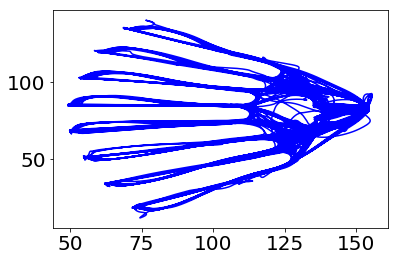

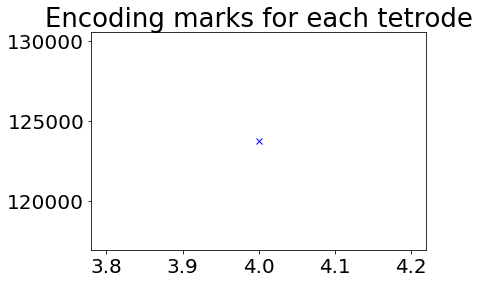

In [73]:
# Encoding input data, position and spikes
# **** time is 30x sec
# total length of pos is 122,000 this is 4,000 seconds or 1hr
# to test linearization of arm 7: pos subset = 6000-8000
subset_start = 0
subset_end = -1
chunkstart = pos.index.get_level_values('time')[subset_start]
chunkend = pos.index.get_level_values('time')[subset_end]
speed_threshold_save = 0; 

# Define path base - moved to linearization cell
#path_base_timewindow = str(int(round(chunkstart))) + 'to' + str(int(round(chunkend))) + 'sec'
#path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

pos_subset = pos.loc[(pos.index.get_level_values('time') <= chunkend) & (pos.index.get_level_values('time') >= chunkstart)]
posY_subset = posY.loc[(posY.index.get_level_values('time') <= chunkend) & (posY.index.get_level_values('time') >= chunkstart)] 
pos_start= pos_subset.index.get_level_values('time')[0]
pos_end = pos_subset.index.get_level_values('time')[-1]
spk_subset = marks.loc[(marks.index.get_level_values('time') <  pos_end) & (marks.index.get_level_values('time') >  pos_start)]
#rip_subset = rips.loc[(rips['starttime'].values >  pos_start) & (rips['endtime'].values <  pos_end)]
rip_subset = rips_vel_filtered.loc[(rips_vel_filtered['starttime'].values >  pos_start) & (rips_vel_filtered['endtime'].values <  pos_end)]

#whole epoch
#spk_subset = marks
#rip_subset = rips_vel_filtered

spk_subset_sparse = trodes2SS.threshold_marks(spk_subset, maxthresh=2000,minthresh=100)
print('original length: '+str(spk_subset.shape[0]))
print('after filtering: '+str(spk_subset_sparse.shape[0]))

spk_subset_sparse.groupby('elec_grp_id')

plt.plot(pos_subset['linpos_flat'].values,posY_subset['linpos_flat'].values,'b')

# Plot marks for each tetrode 
plt.figure()
plt.plot(tetrodes_dictionary[rat_name],spk_subset_sparse.groupby('elec_grp_id').count().values[:,0],'bx')
plt.title('Encoding marks for each tetrode')

In [74]:
# velocity filter for encoding spikes
# note old cells for velocity filter are in "Jens_latest..." notebook

linflat_obj = pos_subset.get_mapped_single_axis()
#linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')

spk_subset_sparse_encode = spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

print('encoding spikes after filtering: '+str(spk_subset_sparse_encode.shape[0]))

encoding spikes after filtering: 48339


In [64]:
spk_subset_sparse_decode_filt.xs(29,level='elec_grp_id')
spk_subset_sparse_encode

<_____SpikeFeatures: None, shape: ((147474, 4))>

0 above 2000uV events removed
0 below 100uV events removed
original length: 123725
after filtering: 123725


Text(0.5,1,'Decoding marks for each tetrode')

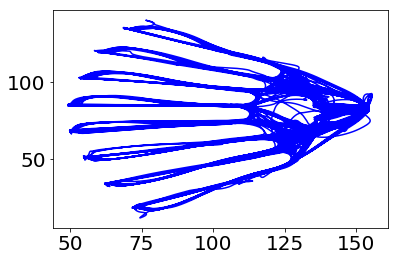

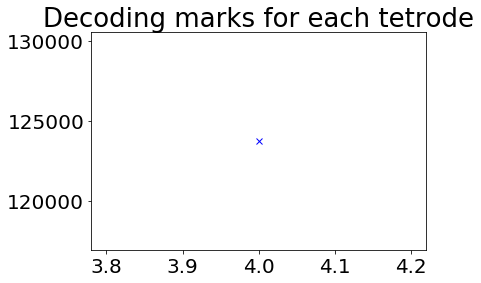

In [75]:
# Decoding input data, position and spikes
# **** time is 30x sec
chunkstart_decode = pos.index.get_level_values('time')[0]
chunkend_decode = pos.index.get_level_values('time')[-1]
speed_threshold_save = 0; 

pos_subset_decode = pos.loc[(pos.index.get_level_values('time') <= chunkend_decode) & (pos.index.get_level_values('time') >= chunkstart_decode)]
posY_subset_decode = posY.loc[(posY.index.get_level_values('time') <= chunkend_decode) & (posY.index.get_level_values('time') >= chunkstart_decode)] 
pos_start_decode = pos_subset_decode.index.get_level_values('time')[0]
pos_end_decode = pos_subset_decode.index.get_level_values('time')[-1]
spk_subset_decode = marks.loc[(marks.index.get_level_values('time') <  pos_end_decode) & (marks.index.get_level_values('time') >  pos_start_decode)]
#rip_subset_decode = rips.loc[(rips['starttime'].values >  pos_start) & (rips['endtime'].values <  pos_end)]
rip_subset_decode = rips_vel_filtered.loc[(rips_vel_filtered['starttime'].values > pos_start_decode) & (rips_vel_filtered['endtime'].values <  pos_end_decode)]

#whole epoch
#spk_subset_decode = marks
#rip_subset_decode = rips_vel_filtered

spk_subset_sparse_decode = trodes2SS.threshold_marks(spk_subset_decode, maxthresh=2000,minthresh=100)
print('original length: '+str(spk_subset_decode.shape[0]))
print('after filtering: '+str(spk_subset_sparse_decode.shape[0]))

spk_subset_sparse_decode.groupby('elec_grp_id')

#plt.rcParams["figure.figsize"] = [12,9]
plt.plot(pos_subset_decode['linpos_flat'].values,posY_subset_decode['linpos_flat'].values,'b')

# Plot marks for each tetrode 
plt.figure()
plt.plot(tetrodes_dictionary[rat_name],spk_subset_sparse_decode.groupby('elec_grp_id').count().values[:,0],'bx')
plt.title('Decoding marks for each tetrode')

In [76]:
#velocity filter for decoding spikes
linflat_obj = pos_subset.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(spk_subset_sparse_decode)
linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < 4')

spk_subset_sparse_decode_filt = spk_subset_sparse_decode.loc[linflat_spkindex_decode_velthresh.index]

print('decoding spikes after filtering: '+str(spk_subset_sparse_decode_filt.shape[0]))

decoding spikes after filtering: 75386


In [ ]:
pos_subset_linear

In [8]:
# linearization for a chunck of data
speed_threshold_save = 0;
linear_start = pos.index.get_level_values('time')[subset_start]
linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization result doesn't exist, do linearization calculation
if os.path.exists(linearization_output1_save_filename) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')

    # Prepare for linearization 
    
    # Create graph elements
    track_graph, track_segments, center_well_id = createTrackGraph(maze_coordinates)
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)

    # Define shift amounts 
    # 1-13-19 trying 10cm bins with flat transition matrix, set hardcode_shiftamount to 20
    # **** 
    hardcode_armorder = hack_determinearmorder(track_segments) # add progressive stagger in this order
    hardcode_shiftamount = 20 # add this stagger to sum of previous shifts
    # ****
    linearization_arm_lengths = []
    # Caculate length of outer arms, plot
    for track_segment in enumerate(track_segments): # for each track segment
        plt.plot(track_segment[1][:,0],track_segment[1][:,1]) # plot track segment
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0])) # label with segment number
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            linearization_arm_lengths.append(np.linalg.norm(track_segment[1][0,:] - track_segment[1][1,:])) # calculate length
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(linearization_arm_lengths[track_segment[0]])) # text to show length 
    # Define dictionary for shifts for each arm segment
    shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 
    for arm in enumerate(hardcode_armorder): # for each outer arm
        if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
            temporary_variable_shift = hardcode_shiftamount 
        else: # if not first arm, add to hardcode_shiftamount length of previous arm 
            temporary_variable_shift = hardcode_shiftamount + linearization_arm_lengths[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
        shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift
    # Plot 
    plt.figure()
    for track_segment in enumerate(track_segments):
        plt.plot(track_segment[1][:,0],track_segment[1][:,1])
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0]))
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(shift_linear_distance_by_arm_dictionary[track_segment[0]]))
        plt.title('large numbers go into linear distance dictionary')
        
    
    # Pull node coordinates (store as node_coords)
    temp2 = [] # list for node coordinates
    for eachnode in track_graph.nodes: # for each node
        temp = list(track_graph.nodes[eachnode]['pos'])
        temp2.append(temp)
    node_coords = np.asarray(temp2)
    # Assign nodes to track segments
    track_segment_id_nodes = lfdp.track_segment_classification.find_nearest_segment(track_segments, node_coords)

    # Calculate linear distance of nodes to back well 
    linear_distance_nodes = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id_nodes, center_well_id, node_coords)

    # Linearize position
    pos_subset_linear = pos.loc[(pos.index.get_level_values('time') <= linear_end) & (pos.index.get_level_values('time') >= linear_start)]
    posY_subset_linear = posY.loc[(posY.index.get_level_values('time') <= linear_end) & (posY.index.get_level_values('time') >= linear_start)] 

    # Vector with position
    simplepos = np.vstack([pos_subset_linear['linpos_flat'],posY_subset_linear['linpos_flat']]) # x pos, y pos
    # Store under different name to plot for debugging 
    simplepos_original = simplepos 

    # Assign each position to a track segment
    # ****
    sensor_std_dev = 1 # 10
    assign_track_segments_one_is_Markov_two_is_naive = 2 # 1 for hidden markov model, 2 for naive
    # ****
    # Define back well
    #center_well_id = 17
    center_well_id = 16
    # HIDDEN MARKOV MODEL:
    # Assign position to track segment
    track_segment_id = lfdp.track_segment_classification.classify_track_segments(track_graph,
                                simplepos.T, sensor_std_dev=sensor_std_dev, route_euclidean_distance_scaling=1)
    # SIMPLER WAY: 
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)
    track_segment_id_naive = lfdp.track_segment_classification.find_nearest_segment(track_segments, simplepos.T)
    # Choose track segment assignment 
    if assign_track_segments_one_is_Markov_two_is_naive == 1:
        track_segment_id_use = track_segment_id
    elif assign_track_segments_one_is_Markov_two_is_naive == 2:   
        track_segment_id_use = track_segment_id_naive
    # Find linear distance of position from back well 
    linear_distance = lfdp.track_segment_classification.calculate_linear_distance(track_graph, 
                                 track_segment_id_use, center_well_id, simplepos.T)

    # Modify: 1) collapse non-arm locations, 2) shift linear distance for the 8 arms
    newseg = np.copy(track_segment_id_use)
    # 1) Collapse non-arm locations
    # newseg[(newseg < 16) & (newseg > 7)] = 8
    # newseg[(newseg == 16)] = 9
    #try making one segment for box
    newseg[(newseg < 17) & (newseg > 7)] = 8
    
    # 2) Shift linear distance for each arm 
    linear_distance_arm_shift = np.copy(linear_distance)
    for seg in shift_linear_distance_by_arm_dictionary:
        linear_distance_arm_shift[(newseg==seg)]+=shift_linear_distance_by_arm_dictionary[seg]  
    # Incorporate modifications 
    plt.figure()
    plt.plot(linear_distance_arm_shift)
    # problem: this pos_subset is next used by the encoder, but now it doesnt match the subset of time for spikes
    # this like is still causing problems, becuase we can plot the position during the decoded time...
    # what is this line doing?
    # okay so we need to linearize the whole eopch and then look-up the encoding time
    # we should be able to use the same indecies eg 5000 - 11000
    pos_subset['linpos_flat']=linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #pos_subset_decode is only required for visualization
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]

    # Store some linearization results in python format for quick loading (pos_subset) 
    np.save(linearization_output1_save_filename, linear_distance_arm_shift)
    np.save(linearization_output2_save_filename, track_segment_id_use)
    
    
    
    # Save some linearization results in .mat file
    # Convert dictionary with shift for each arm to array since matlab can't read the dictionary 
    linearization_shift_segments_list = []
    for key in shift_linear_distance_by_arm_dictionary:
        temp = [key,shift_linear_distance_by_arm_dictionary[key]]
        linearization_shift_segments_list.append(temp)    
    # Change directory
    change_to_directory_make_if_nonexistent(linearization_output_save_path)
    # Define file name 
    file_name_temp = [rat_name + '_day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0]) + 
                      '_' + path_base_timewindow +
                      '_speed' + str(speed_threshold_save) + 
                      '_linearization_variables.mat']    

    # Store variables 
    export_this = AttrDict({'linearization_segments': track_segments,
                            'linearization_nodes_coordinates': node_coords,
                            'linearization_nodes_distance_to_back_well':linear_distance_nodes,
                            'linearization_shift_segments_list': linearization_shift_segments_list,
                            'linearization_position_segments':track_segment_id_use,
                            'linearization_position_distance_from_back_well':linear_distance,
                            'linearization_position_distance_from_back_well_arm_shift':linear_distance_arm_shift
                           })
    # Warn before overwriting file 
    if os.path.exists(file_name_temp[0]) == True:
        input("Press Enter to overwrite file")
        print('overwriting')
    # Save 
    print('saving file:',file_name_temp)
    sio.savemat(file_name_temp[0],export_this)
    
    

# If linearization result exists, load it 
else:
    print('Linearization result exists. Loading it.')
    linear_distance_arm_shift = np.load(linearization_output1_save_filename)
    #test = np.load(linearization_output3_save_filename)
    track_segment_id_use = np.load(linearization_output2_save_filename)
    pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #for whole epoch when using -1
    #pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start):(subset_end)]
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    

Linearization result exists. Loading it.


(10001,)

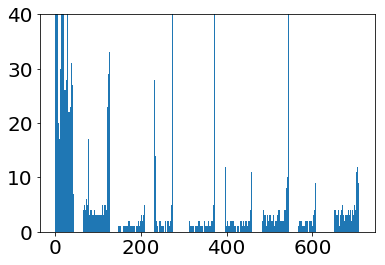

In [9]:
#plt.hist(track_segment_id_use)
plt.hist(pos_subset['linpos_flat'],709)
plt.ylim(0,40)
linear_distance_arm_shift.shape

In [155]:
%%time
# linearize the whole epoch - this gets rid of the pos_subset variables and linearizes position of whole epoch

encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# variables for all position data
pos_all_linear = datasrc.import_pos(encode_settings, xy='x')
posY1 = datasrc.import_pos(encode_settings, xy='y')
speed_threshold_save = 0;

#linear_start = pos.index.get_level_values('time')[subset_start]
#linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
#path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_timewindow = 'whole_epoch_v2'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization result doesn't exist, do linearization calculation
if os.path.exists(linearization_output1_save_filename) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')

    # Prepare for linearization 
    
    # Create graph elements
    track_graph, track_segments, center_well_id = createTrackGraph(maze_coordinates)
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)

    # Define shift amounts 
    # 1-13-19 trying 10cm bins with flat transition matrix, set hardcode_shiftamount to 20
    # **** 
    hardcode_armorder = hack_determinearmorder(track_segments) # add progressive stagger in this order
    hardcode_shiftamount = 20 # add this stagger to sum of previous shifts
    # ****
    linearization_arm_lengths = []
    # Caculate length of outer arms, plot
    for track_segment in enumerate(track_segments): # for each track segment
        plt.plot(track_segment[1][:,0],track_segment[1][:,1]) # plot track segment
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0])) # label with segment number
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            linearization_arm_lengths.append(np.linalg.norm(track_segment[1][0,:] - track_segment[1][1,:])) # calculate length
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(linearization_arm_lengths[track_segment[0]])) # text to show length 
    # Define dictionary for shifts for each arm segment
    shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 
    for arm in enumerate(hardcode_armorder): # for each outer arm
        if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
            temporary_variable_shift = hardcode_shiftamount 
        else: # if not first arm, add to hardcode_shiftamount length of previous arm 
            temporary_variable_shift = hardcode_shiftamount + linearization_arm_lengths[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
        shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift
    # Plot 
    plt.figure()
    for track_segment in enumerate(track_segments):
        plt.plot(track_segment[1][:,0],track_segment[1][:,1])
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0]))
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(shift_linear_distance_by_arm_dictionary[track_segment[0]]))
        plt.title('large numbers go into linear distance dictionary')
        
    
    # Pull node coordinates (store as node_coords)
    temp2 = [] # list for node coordinates
    for eachnode in track_graph.nodes: # for each node
        temp = list(track_graph.nodes[eachnode]['pos'])
        temp2.append(temp)
    node_coords = np.asarray(temp2)
    # Assign nodes to track segments
    track_segment_id_nodes = lfdp.track_segment_classification.find_nearest_segment(track_segments, node_coords)

    # Calculate linear distance of nodes to back well 
    linear_distance_nodes = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id_nodes, center_well_id, node_coords)

    # Linearize position
    #pos_subset_linear = pos.loc[(pos.index.get_level_values('time') <= linear_end) & (pos.index.get_level_values('time') >= linear_start)]
    #posY_subset_linear = posY.loc[(posY.index.get_level_values('time') <= linear_end) & (posY.index.get_level_values('time') >= linear_start)] 

    # Vector with position
    #simplepos = np.vstack([pos_subset_linear['linpos_flat'],posY_subset_linear['linpos_flat']]) # x pos, y pos
    simplepos = np.vstack([pos_all_linear['linpos_flat'],posY1['linpos_flat']]) # x pos, y pos
    # Store under different name to plot for debugging 
    simplepos_original = simplepos 

    # Assign each position to a track segment
    # ****
    sensor_std_dev = 1 # 10
    assign_track_segments_one_is_Markov_two_is_naive = 2 # 1 for hidden markov model, 2 for naive
    # ****
    # Define back well
    #center_well_id = 17
    center_well_id = 16
    # HIDDEN MARKOV MODEL:
    # Assign position to track segment
    track_segment_id = lfdp.track_segment_classification.classify_track_segments(track_graph,
                                simplepos.T, sensor_std_dev=sensor_std_dev, route_euclidean_distance_scaling=1)
    # SIMPLER WAY: 
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)
    track_segment_id_naive = lfdp.track_segment_classification.find_nearest_segment(track_segments, simplepos.T)
    # Choose track segment assignment 
    if assign_track_segments_one_is_Markov_two_is_naive == 1:
        track_segment_id_use = track_segment_id
    elif assign_track_segments_one_is_Markov_two_is_naive == 2:   
        track_segment_id_use = track_segment_id_naive
    # Find linear distance of position from back well 
    linear_distance = lfdp.track_segment_classification.calculate_linear_distance(track_graph, 
                                 track_segment_id_use, center_well_id, simplepos.T)

    # Modify: 1) collapse non-arm locations, 2) shift linear distance for the 8 arms
    newseg = np.copy(track_segment_id_use)
    # 1) Collapse non-arm locations
    # newseg[(newseg < 16) & (newseg > 7)] = 8
    # newseg[(newseg == 16)] = 9
    #try making one segment for box
    newseg[(newseg < 17) & (newseg > 7)] = 8
    
    # 2) Shift linear distance for each arm 
    linear_distance_arm_shift = np.copy(linear_distance)
    for seg in shift_linear_distance_by_arm_dictionary:
        linear_distance_arm_shift[(newseg==seg)]+=shift_linear_distance_by_arm_dictionary[seg]  
    # Incorporate modifications 
    plt.figure()
    plt.plot(linear_distance_arm_shift)
    # problem: this pos_subset is next used by the encoder, but now it doesnt match the subset of time for spikes
    # this like is still causing problems, becuase we can plot the position during the decoded time...
    # what is this line doing?
    # okay so we need to linearize the whole eopch and then look-up the encoding time
    # we should be able to use the same indecies eg 5000 - 11000
    pos_all_linear['linpos_flat']=linear_distance_arm_shift
    
    #pos_subset_decode is only required for visualization
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]

    # Store some linearization results in python format for quick loading (pos_subset) 
    np.save(linearization_output1_save_filename, linear_distance_arm_shift)
    np.save(linearization_output2_save_filename, track_segment_id_use)
    
    
    
    # Save some linearization results in .mat file
    # Convert dictionary with shift for each arm to array since matlab can't read the dictionary 
    linearization_shift_segments_list = []
    for key in shift_linear_distance_by_arm_dictionary:
        temp = [key,shift_linear_distance_by_arm_dictionary[key]]
        linearization_shift_segments_list.append(temp)    
    # Change directory
    change_to_directory_make_if_nonexistent(linearization_output_save_path)
    # Define file name 
    file_name_temp = [rat_name + '_day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0]) + 
                      '_' + path_base_timewindow +
                      '_speed' + str(speed_threshold_save) + 
                      '_linearization_variables.mat']    

    # Store variables 
    export_this = AttrDict({'linearization_segments': track_segments,
                            'linearization_nodes_coordinates': node_coords,
                            'linearization_nodes_distance_to_back_well':linear_distance_nodes,
                            'linearization_shift_segments_list': linearization_shift_segments_list,
                            'linearization_position_segments':track_segment_id_use,
                            'linearization_position_distance_from_back_well':linear_distance,
                            'linearization_position_distance_from_back_well_arm_shift':linear_distance_arm_shift
                           })
    # Warn before overwriting file 
    if os.path.exists(file_name_temp[0]) == True:
        input("Press Enter to overwrite file")
        print('overwriting')
    # Save 
    print('saving file:',file_name_temp)
    sio.savemat(file_name_temp[0],export_this)
    
    

# If linearization result exists, load it 
else:
    print('Linearization result exists. Loading it.')
    linear_distance_arm_shift = np.load(linearization_output1_save_filename)
    #test = np.load(linearization_output3_save_filename)
    track_segment_id_use = np.load(linearization_output2_save_filename)
    #pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #for whole epoch 
    pos_all_linear['linpos_flat'] = linear_distance_arm_shift
    

Linearization result exists. Loading it.
CPU times: user 333 ms, sys: 50.6 ms, total: 383 ms
Wall time: 601 ms


In [251]:
#new_pos_all_linear = pos_all_linear
pos_all_linear
new_pos_all_linear

<FlatLinearPosition: None, shape: ((122655, 2))>

(122655, 2)

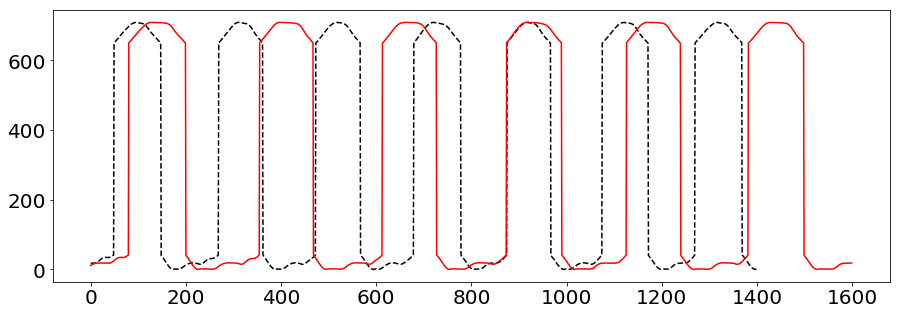

In [340]:
vel_new_pos_all_linear = new_pos_all_linear.loc[(new_pos_all_linear["linvel_flat"]>4)]
vel_pos_all_linear = pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)]

plt.plot(vel_new_pos_all_linear['linpos_flat'].values[10100:11500],'k',linestyle='dashed')
plt.plot(vel_pos_all_linear['linpos_flat'].values[11600:13200],'r')
#plt.hist(pos_all_linear['linpos_flat'],709)
#plt.hist(new_pos_all_linear['linpos_flat'],709,alpha=0.7)

#plt.ylim(0,40)
new_pos_all_linear.shape

In [ ]:
#randomize trial order for linear position
    #read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])
print('Number of trials: ',trialsindex.shape)


    # randomize trial order
#indices = np.arange(starttimes.shape[0])
#np.random.shuffle(indices)

    #fixed random order
indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
6,  76,  13,  82,  18,  25,  64,  96,  20,  16,  65,  54,  12,  24,  56,   5,  74,  73, 
79,  89,  97,  70,  68,  46,   7,  40, 101,  48,  77,  63,  69, 108,  66,  15,  91,  33, 
45,  21,  51,  19,  30,  23,  72,  35,  42,  47,  95, 107, 104,  61,  43,  60,  67,  88, 
71,  14,  38,  32,  87,  57,  27,  31,   1,   2,  53,  86,  50,  49,   0,  52,  90,  10, 
44,  84,  55,  81, 106,  39,  75,  58,   9,  34,   4,   8,  26,  22,  94,  83,  36,  80, 99]

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]

    #to make a new position, marks and trial file with new start and end times:
     #position
#random_trial_pos_all = pos_all_linear.head(0)
#for i in range(len(starttimes_shuffled)):
#    random_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
#    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)

random_trial_pos_all = pos.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)



In [106]:
#shift_linear_distance_by_arm_dictionary
#pos[0:5000].shape
#pos1 = pos[0:5000]
#posY1 = posY[0:5000]
random_trial_pos_all
pos_all_linear[405:425]
#marks_reset = marks.reset_index()
#pos_all_linear.query('linpos_flat == 2.7260 & linvel_flat == 4.0537')
#pos_all_linear.query('linpos_flat == 2')

pos_linear_round = pos_all_linear.round(4)
pos_linear_round_reset = pos_linear_round.reset_index()
pos_linear_round_reset.query('linpos_flat == 2.7278 & linvel_flat == 3.7057')

random_trial_pos_all_round = random_trial_pos_all.round(4)
random_trial_pos_all_round_reset = random_trial_pos_all_round.reset_index()
random_trial_pos_all_round_reset.query('linpos_flat == 2.7260 & linvel_flat == 4.0537')

,day,epoch,timestamp,time,linpos_flat,linvel_flat
92612,20,2,41270020,1375.6673,2.726,4.0537


In [14]:
linear_distance_arm_shift.shape
len(linear_distance_arm_shift)

122663

In [79]:
# Define position bins #!!! HARD CODE: ASSUMES POSITION BIN OF WIDTH 1 !!!
# need to use the indices of the encoding time subset in this cell

# Initialize variables 
tracksegment_positionvalues_min_and_max = []
tracksegment_positionvalues_for_bin_edges = [] 

# Find min and max position for each track segment 
#tracksegments_temp = np.unique(track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)])
#whole epoch
tracksegments_temp = np.unique(track_segment_id_use[0:len(linear_distance_arm_shift)])

for t_loop in tracksegments_temp: # for each track segment
    #indiceswewant_temp = track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)] == t_loop
    #whole epoch
    indiceswewant_temp = track_segment_id_use[0:len(linear_distance_arm_shift)] == t_loop
    
    #tracksegment_positionvalues_temp = pos_subset.values[indiceswewant_temp,0] # second dimension of pos_subset: zero for position, 1 for velocity
    #whole epoch
    tracksegment_positionvalues_temp = pos_all_linear.values[indiceswewant_temp,0]
    
    tracksegment_positionvalues_min_and_max.append([tracksegment_positionvalues_temp.min(), tracksegment_positionvalues_temp.max()])
    
    # To define edges, floor mins and ceil maxes
    tracksegment_positionvalues_for_bin_edges.append([np.floor(tracksegment_positionvalues_temp.min()), np.ceil(tracksegment_positionvalues_temp.max())])

# Floor to get bins #? Is this right? Does 0 mean the bin spanning [0, 1]?
tracksegment_positionvalues_min_and_max_floor = np.floor(tracksegment_positionvalues_min_and_max)

# Find only bins in range of segments
binswewant_temp = []
for t_loop in tracksegment_positionvalues_min_and_max_floor: # for each track segment
    binswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index
# Do same for edges
edgeswewant_temp = []
for t_loop in tracksegment_positionvalues_for_bin_edges: # for each track segment
    edgeswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index

# Flatten (combine bins from segments)
binswewant_temp_flat = [y for x in binswewant_temp for y in x]
edgeswewant_temp_flat = [y for x in edgeswewant_temp for y in x]

# Find unique elements
arm_coords_wewant = (np.unique(binswewant_temp_flat))
edges_wewant = (np.unique(edgeswewant_temp_flat))

# Turn list of edges into ranges 
start_temp, end_temp = turn_array_into_ranges(edges_wewant)
arm_coordinates_WEWANT = np.column_stack((start_temp, end_temp))

# Print/plot
# Plot position values
# plt.plot(tracksegment_positionvalues_min_and_max_floor)
# print(arm_coords_wewant)
print(arm_coordinates_WEWANT)
# type(arm_coords_wewant)
# plt.figure()
# plt.plot(arm_coords_wewant)


[[  0.  45.]
 [ 64. 128.]
 [146. 210.]
 [230. 275.]
 [311. 373.]
 [397. 459.]
 [482. 544.]
 [563. 610.]
 [649. 710.]]


In [80]:
# this cell is to speed up encoding with larger position bins
# try 5cm bins - do this by dividing position subset by 5 and arm coords by 5

# need to use pos1 - contains linearized position
#pos_subset['linpos_flat'] = (pos_subset['linpos_flat'])/5

#whole epoch
pos_all_linear['linpos_flat'] = (pos_all_linear['linpos_flat'])/5

#plt.figure(figsize=(12,8))
#plt.plot((linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)])/5)
#plt.plot((linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]))
#plt.plot((linear_distance_arm_shift[(40000):(50000)]))
#pos_subset['linpos_flat'][3000:3010]

arm_coordinates_WEWANT = arm_coordinates_WEWANT/5
arm_coordinates_WEWANT = np.around(arm_coordinates_WEWANT)
arm_coordinates_WEWANT

array([[  0.,   9.],
       [ 13.,  26.],
       [ 29.,  42.],
       [ 46.,  55.],
       [ 62.,  75.],
       [ 79.,  92.],
       [ 96., 109.],
       [113., 122.],
       [130., 142.]])

(0, 40)

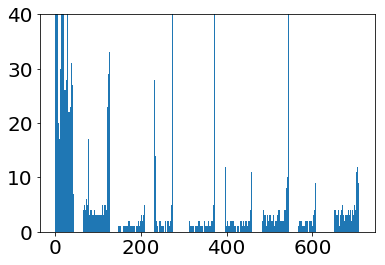

In [82]:
plt.hist(pos_subset['linpos_flat'],709)
plt.ylim(0,40)

In [81]:
# Define encoding settings #? Ideally would only define once
# we dont have a bin for the blank 15cm bin between each segment
# 1-13-19 update bin info for 10cm bins - removed because these changes didnt work:
# the encoding went everywhere and didnt adhere to the gaps between the arms
# the extra added to max_pos matched the hardcoded gap from the linearization

#max_pos = int(round(linear_distance_arm_shift.max()) + 20)

# to use for 5cm bins
max_pos = int(round(linear_distance_arm_shift.max()/5) + 5)

encode_settings = AttrDict({'sampling_rate': 3e4,
                            'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                            'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                            'pos_bin_delta': 1,
                            # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                            'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1), 
                            'pos_kernel_std': 1, 
                            'mark_kernel_std': int(20), 
                            'pos_num_bins': max_pos, # len(arm_coords_wewant)
                            'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # or range(0,max_pos,10)
                            'arm_coordinates': arm_coordinates_WEWANT}) # includes box, removes bins in the gaps 'arm_coordinates': [[0,max_pos]]})



In [82]:
#define decode settings
decode_settings = AttrDict({'trans_smooth_std': 2,
                            'trans_uniform_gain': 0.0001,
                            'time_bin_size':60})

<FlatLinearPosition: None, shape: ((122663, 2))>

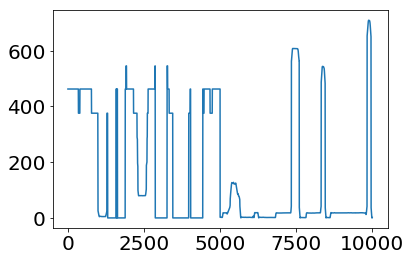

In [48]:
plt.plot(linear_distance_arm_shift[1:10000])
#pos = datasrc.import_pos(encode_settings, xy='x')
pos_all_linear

In [29]:
# break up marks into 80/20 split for encoder and decoder
# we want to use the same subset of position for encoding - because we are doing occupancy normalization
# note it should be easiest to run velocity filter first on marks from whole epoch

# 80% for encoding - marks
spk_subset1 = spk_sparse_all.loc[(spk_sparse_all.index.get_level_values('time') <  pos.index.get_level_values('time')[5000]) & (spk_sparse_all.index.get_level_values('time') >  pos.index.get_level_values('time')[0])]
spk_subset2 = spk_sparse_all.loc[(spk_sparse_all.index.get_level_values('time') <  pos.index.get_level_values('time')[13000]) & (spk_sparse_all.index.get_level_values('time') >  pos.index.get_level_values('time')[6000])]
spk_subset_encode_crossval = spk_subset1.append(spk_subset2)

# 80% for encoding - linearized position
pos_subset1 = pos_all_linear.loc[(pos.index.get_level_values('time') <= pos.index.get_level_values('time')[5000]) & (pos.index.get_level_values('time') >= pos.index.get_level_values('time')[0])]
pos_subset2 = pos_all_linear.loc[(pos.index.get_level_values('time') <= pos.index.get_level_values('time')[13000]) & (pos.index.get_level_values('time') >= pos.index.get_level_values('time')[6000])]
pos_subset_crossval = pos_subset1.append(pos_subset2)
pos_subset_crossval_vel = pos_subset_crossval.loc[(pos_subset_crossval["linvel_flat"]>2)]

# 20% for decoding - marks
spk_subset_decode_crossval = spk_sparse_all.loc[(spk_sparse_all.index.get_level_values('time') <  pos.index.get_level_values('time')[20000]) & (spk_sparse_all.index.get_level_values('time') >  pos.index.get_level_values('time')[12000])]
#spk_subset_decode_crossval = marks.loc[(marks.index.get_level_values('time') <  pos.index.get_level_values('time')[17000]) & (marks.index.get_level_values('time') >  pos.index.get_level_values('time')[12000])]

In [ ]:
pos_subset_crossval

In [14]:
%%time
# note: notch filter is currently hard-coded into pp_clusterless.py - removed 3-31-19
#8-31:remove speed_thresh, add dec_spk_amp, add decode_settings
# these time-table lines are so that we can record the time it takes for encoder to run even if notebook disconnects
# look at the time stamps for the two files in /data2/mcoulter called time_stamp1 and time_stamp2
time_table_data = {'age': [1, 2, 3, 4, 5]}
time_table = pd.DataFrame(time_table_data)
time_table.to_csv('/mnt/vortex/mcoulter/time_stamp1.csv')

# for whole epoch: use linflat=pos1
# for subset: use linflat=pos_subset
# original: dec_spk_amp=spk_subset_sparse_decode
# original: enc_spk_amp=spk_subset_sparse_encode

encoder = OfflinePPEncoder(linflat=pos_subset, dec_spk_amp=spk_subset_sparse_decode_filt, encode_settings=encode_settings, 
                           decode_settings=decode_settings, enc_spk_amp=spk_subset_sparse_encode, dask_worker_memory=1e9,
                           dask_chunksize = None)

#encoder.run_encoder(directory_pickling)
encoder_output = encoder.run_encoder()
results = encoder_output['results']
prob_no_spike = encoder_output['prob_no_spike']
trans_mat = encoder_output['trans_mat']

time_table.to_csv('/mnt/vortex/mcoulter/time_stamp2.csv')

10:58:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 423
10:58:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 50.0%
10:58:45 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 475.93 MB


convolution occupancy normalization


INFO:root:Setting up encoder dask task.
INFO:root:Running compute tasks on dask workers.


CPU times: user 6min 45s, sys: 4min 54s, total: 11min 39s
Wall time: 1min 7s


In [99]:
#prob_no_spike_26 = prob_no_spike
#results_26 = results
#results_28 = results
#prob_no_spike_28 = prob_no_spike
#results_29 = results
#prob_no_spike_29 = prob_no_spike
#results_30 = results
#prob_no_spike_30 = prob_no_spike
#np.save('/mnt/vortex/mcoulter/prob_no_spike.npy', prob_no_spike)
#prob_no_spike_all = prob_no_spike_26.update(prob_no_spike_28)
tet_ids = [prob_no_spike_26,prob_no_spike_28,prob_no_spike_29,prob_no_spike_30]
tet_ids[0]
#name = 'prob_no_spike_' + str(tet_ids[1])
#name
prob_no_spike_all = tet_ids[0]
for tet_id in tet_ids[1:]:
    prob_no_spike_all.update(tet_id)
#prob_no_spike_all.update(prob_no_spike_29)
prob_no_spike_all
#tet_ids[-1]

{26: array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 9.99999999e-001, 9.99995699e-001,
        9.95294383e-001, 1.49141181e-001, 2.24391178e-123, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.24391178e-123,
        1.49141181e-001, 9.95294383e-001, 9.99995699e-001, 9.99999999e-001,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 9.99999968e-001, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 9.99461625e-001, 9.99522722e-001,
        9.99563251e-001, 9.99567153e-001, 9.99509823e-001, 9.99338218e-001,
        

In [100]:
ratz = ['remy','bernard','fievel']
for ratz_name in ratz:
    rat_name = ratz_name
    print(rat_name)

remy
bernard
fievel


In [100]:
trans_mat
np.save('/mnt/vortex/mcoulter/trans_mat.npy', trans_mat)

In [102]:
np.load('/mnt/vortex/mcoulter/trans_mat.npy').shape

(147, 147)

In [15]:
%%time
#from dan notebook decoding/encoding_alogrithm
#to make observations table from results

#tet_ids = np.unique(spk_subset_sparse_decode.index.get_level_values('elec_grp_id'))
#tet_ids = np.unique(spk_subset_sparse.index.get_level_values('elec_grp_id'))
tet_ids = np.unique(spk_subset_sparse_decode_filt.index.get_level_values('elec_grp_id'))
observ_tet_list = []
#grp = spk_subset_sparse_decode.groupby('elec_grp_id')
#grp = spk_subset_sparse.groupby('elec_grp_id')
grp = spk_subset_sparse_decode_filt.groupby('elec_grp_id')
for tet_ii, (tet_id, grp_spk) in enumerate(grp):
    tet_result = results[tet_ii]
    tet_result.set_index(grp_spk.index, inplace=True)
    observ_tet_list.append(tet_result)

observ = pd.concat(observ_tet_list)
observ_obj = SpikeObservation.create_default(observ.sort_index(level=['day', 'epoch', 
                                                                      'timestamp', 'elec_grp_id']), 
                                             encode_settings)

observ_obj['elec_grp_id'] = observ_obj.index.get_level_values('elec_grp_id')
observ_obj.index = observ_obj.index.droplevel('elec_grp_id')

CPU times: user 2 s, sys: 990 ms, total: 2.99 s
Wall time: 353 ms


In [ ]:
#make a similiar cell to the one above for stitching together the prob_no_spike dictionary from individual tetrodes
encoder.prob_no_spike[6]


In [16]:
observ_obj

<SpikeObservation: None, shape: ((154326, 148))>

In [39]:
# this changes number of displayed rows of a pandas dataframe
pd.options.display.max_rows = 20

pos_subset.loc[(pos_subset["linvel_flat"]>4)]
pos_subset_flat = pos_subset.reset_index()
pos_subset_flat.loc[(pos_subset_flat["time"]>1372.2) & (pos_subset_flat["time"]<1375.8)]


,day,epoch,timestamp,time,linpos_flat,linvel_flat
315,20,2,41166137,1372.2046,0.2642,3.3598
316,20,2,41167145,1372.2382,0.2642,3.6604
317,20,2,41168155,1372.2718,0.2642,3.9853
318,20,2,41169163,1372.3054,0.2642,4.3334
319,20,2,41170171,1372.3390,0.2642,4.7031
320,20,2,41171180,1372.3727,0.2675,5.0925
321,20,2,41172189,1372.4063,0.2637,5.4989
322,20,2,41173197,1372.4399,0.2568,5.9193
323,20,2,41174206,1372.4735,0.1924,6.3502
324,20,2,41175214,1372.5071,0.1171,6.7879


In [42]:
observ_obj_flat = observ_obj.reset_index()
observ_obj_flat.loc[(observ_obj_flat["time"]>1372.2) & (observ_obj_flat["time"]<1375.7)]

,day,epoch,timestamp,time,x000,x001,x002,...,x141,x142,x143,x144,x145,x146,elec_grp_id
16264,20,2,41166030,1372.2010,0.0101,0.0089,0.0064,...,2.5397e-09,4.0466e-09,5.8897e-09,8.2886e-09,1.1524e-08,1.5953e-08,21
16265,20,2,41166041,1372.2014,0.0050,0.0052,0.0055,...,5.3022e-03,3.8121e-03,2.9994e-03,2.7159e-03,2.7894e-03,3.1266e-03,26
16266,20,2,41166046,1372.2015,0.1175,0.1662,0.2597,...,4.3233e-05,5.0695e-05,5.4183e-05,5.5980e-05,5.7160e-05,5.8164e-05,30
16267,20,2,41166071,1372.2024,0.0020,0.0020,0.0023,...,3.6057e-03,3.2386e-03,3.4602e-03,4.0535e-03,4.9829e-03,6.2997e-03,23
16268,20,2,41166080,1372.2027,0.0006,0.0008,0.0013,...,4.2857e-04,3.6583e-04,3.2298e-04,3.2168e-04,3.6521e-04,4.5698e-04,29
16269,20,2,41166086,1372.2029,0.0015,0.0018,0.0029,...,4.2000e-03,3.9634e-03,3.8983e-03,4.1560e-03,4.7587e-03,5.7242e-03,26
16270,20,2,41166094,1372.2031,0.0009,0.0011,0.0015,...,2.0185e-03,1.4929e-03,1.4334e-03,1.6055e-03,1.9423e-03,2.4463e-03,21
16271,20,2,41166094,1372.2031,0.0057,0.0079,0.0116,...,4.7837e-03,2.2471e-03,1.1458e-03,7.3039e-04,6.1958e-04,6.6049e-04,22
16272,20,2,41166120,1372.2040,0.0014,0.0015,0.0020,...,2.2872e-03,1.8540e-03,1.8968e-03,2.1931e-03,2.6908e-03,3.4100e-03,9
16273,20,2,41166123,1372.2041,0.0014,0.0016,0.0021,...,3.1928e-03,2.6052e-03,2.7044e-03,3.1755e-03,3.9490e-03,5.0599e-03,20


In [55]:
sum(np.concatenate([np.clip(np.diff(observ_obj['dec_bin'])-1, 0, None), [0]]))
np.diff(observ_obj['dec_bin'])
(np.clip(np.diff(observ_obj['dec_bin'])-1, 0, None)).shape
range(int(num_missing_bins))

NameError: name 'num_missing_bins' is not defined

In [60]:
test_obj = observ_obj.update_num_missing_future_bins()
test_obj_flat = test_obj.reset_index()
test_obj_flat
test_obj_flat.loc[(test_obj_flat["time"]>1372.2) & (test_obj_flat["time"]<1375.7)]

,day,epoch,timestamp,time,x000,x001,x002,...,x146,elec_grp_id,dec_bin,dec_bin_start,num_missing_bins,parallel_bin,vel_filter_bins
16264,20,2,41166030,1372.2010,0.0101,0.0089,0.0064,...,1.5953e-08,21,5563,41166000,0,5,0
16265,20,2,41166041,1372.2014,0.0050,0.0052,0.0055,...,3.1266e-03,26,5563,41166000,0,5,0
16266,20,2,41166046,1372.2015,0.1175,0.1662,0.2597,...,5.8164e-05,30,5563,41166000,0,5,0
16267,20,2,41166071,1372.2024,0.0020,0.0020,0.0023,...,6.2997e-03,23,5564,41166060,0,5,0
16268,20,2,41166080,1372.2027,0.0006,0.0008,0.0013,...,4.5698e-04,29,5564,41166060,0,5,0
16269,20,2,41166086,1372.2029,0.0015,0.0018,0.0029,...,5.7242e-03,26,5564,41166060,0,5,0
16270,20,2,41166094,1372.2031,0.0009,0.0011,0.0015,...,2.4463e-03,21,5564,41166060,0,5,0
16271,20,2,41166094,1372.2031,0.0057,0.0079,0.0116,...,6.6049e-04,22,5564,41166060,0,5,0
16272,20,2,41166120,1372.2040,0.0014,0.0015,0.0020,...,3.4100e-03,9,5564,41166060,0,5,0
16273,20,2,41166123,1372.2041,0.0014,0.0016,0.0021,...,5.0599e-03,20,5565,41166120,0,5,0


In [43]:
%%time
# do we need this cell anymore???
# yes! this prevents 0s in the observation table and then prevents NaN from showing up in the likelihoods

# Add small offset to observation distributions to prevent numerical instability due to precision# Add sm 
#observ_obj.loc[:, 'x000':'x740'] = observ_obj.loc[:, 'x000':'x740'].values + 1e-20
observ_obj.loc[:, 'x000':'x146'] = observ_obj.loc[:, 'x000':'x146'].values + np.spacing(1)

CPU times: user 9.79 s, sys: 1.99 s, total: 11.8 s
Wall time: 9.02 s


In [104]:
# to store observations table
#observ_obj[17245:17255]
#observ_obj.to_csv('/data2/mcoulter/observations_object_1cm-2-3-19.csv')
observ_obj._to_hdf_store('/mnt/vortex/mcoulter/remy_20_2_observ_0_10000_test.h5','/analysis', 
                         'decode/clusterless/offline/observ_obj', 'observ_obj')

# to store observations for a single ripple
#observ_obj = observ_obj.reset_index()
#ripple_obs = observ_obj.loc[(observ_obj["time"]>2864.49) & (observ_obj["time"]<2864.706)]
#ripple_obs.to_csv('/data2/mcoulter/observations_ripple_362.csv')

In [13]:
# hacky but reliable way to load a dataframe stored as hdf
# Posteriors is imported from data_containers
observ_obj = Posteriors._from_hdf_store('/mnt/vortex/mcoulter/remy_20_2_observ_0_10000_test.h5','/analysis', 
                         'decode/clusterless/offline/observ_obj', 'observ_obj')

In [14]:
#load prob_no_spike - this is a dictionary
probability_no_spike = np.load('/mnt/vortex/mcoulter/prob_no_spike.npy').item()
#np.load('/mnt/vortex/mcoulter/prob_no_spike.npy').item()

In [15]:
#load transition matrix - this is an array
transition_matrix = np.load('/mnt/vortex/mcoulter/trans_mat.npy')

In [126]:
%%time
# Run PP decoding algorithm
# NOTE 1-11-19 had to add spk_amp and vel to encode settings in order for decoding to run
# from bond_single.json, vel = 0 and spk_amp = 60

time_bin_size = 60

# note: if you change trans_uniform_gain here it will not get updated when making the transition matrix :(
decode_settings = AttrDict({'trans_smooth_std': 2,
                            'trans_uniform_gain': 0.0001,
                            'time_bin_size':60})

encode_settings = AttrDict({'sampling_rate': 3e4,
                            'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                            'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                            'pos_bin_delta': 1, 
                            # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                            'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1),    
                            'pos_kernel_std': 1, 
                            'mark_kernel_std': int(20), 
                            'pos_num_bins': max_pos, # len(arm_coords_wewant)
                            'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # [pos_col_format(int(ii), len(arm_coords_wewant)) for ii in arm_coords_wewant],
                            'arm_coordinates': arm_coordinates_WEWANT, # 'arm_coordinates': [[0,max_pos]]})
                            #'arm_coordinates': ([[0,53],[74,140],[151,221],[236,285],[311,378],[397,460],[484,486],[565,615],[659,725]]),
                            'spk_amp': 60,
                            'vel': 0})

#when you run the encoder and decoder at same time: trans_mat=encoder.trans_mat['flat_powered']
#AND  prob_no_spike=encoder.prob_no_spike
#when loading a previsouly generated observations table use: trans_mat=transition_matrix
# AND prob_no_spike=probability_no_spike
# added all_linear_position argument for velocity filter of likelihood

decoder = OfflinePPDecoder(observ_obj=observ_obj, trans_mat=encoder.trans_mat['flat_powered'], 
                           prob_no_spike=encoder.prob_no_spike,
                           encode_settings=encode_settings, decode_settings=decode_settings, 
                           time_bin_size=time_bin_size, all_linear_position = pos_subset, 
                          velocity_filter=4)

posteriors = decoder.run_decoder()
#likelihoods = decoder.run_decoder()


decoder deleting
Beginning likelihood calculation
Beginning posterior calculation
CPU times: user 40.8 s, sys: 34.5 s, total: 1min 15s
Wall time: 21.1 s


In [129]:
decoder.likelihoods[0:2]
#for link_ii, like in enumerate(decoder.likelihoods[0:2]):
#    #print(like)
#    np.any(np.nan)


x000        x001        x002        x003  \
day epoch timestamp time                                                       
20  2     40832220  1361.074  2.3949e-03  2.3854e-03  2.3079e-03  1.6484e-03   
          40832280  1361.076  1.9396e-09  1.0650e-08  8.6763e-08  6.9857e-08   

                                    x004        x005    x006   ...     \
day epoch timestamp time                                       ...      
20  2     40832220  1361.074  1.7198e-03  3.3876e-03  0.0090   ...      
          40832280  1361.076  2.2995e-07  6.8387e-06  0.0004   ...      

                                    x142        x143        x144        x145  \
day epoch timestamp time                                                       
20  2     40832220  1361.074  2.2633e-03  2.1350e-03  2.2228e-03  2.4553e-03   
          40832280  1361.076  1.6877e-08  1.0499e-08  9.4243e-09  1.0857e-08   

                                    x146  num_spikes  dec_bin  
day epoch timestamp time                                       
20  2     40832220  1361.074  2.8041e-03         1.0      0.0  
          40832280  1361.076  1.4181e-08         4.0      1.0  

[2 rows x 149 columns]

In [82]:
range(len(encode_settings['pos_col_names']))
trans_mat.shape
encode_settings['arm_coordinates'][0]
pos_subset

<_FlatLinearPosition: None, shape: ((10001, 2))>

In [164]:
# export posteriors to netcdf with eric's new code
import xarray as xr
post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
posterior_df = post1.reset_index()

is_position_bin = posterior_df.columns.str.startswith('x') 
n_position_bins = is_position_bin.sum()
position_bin_centers = np.arange(n_position_bins)
        
coords = dict(
    day=posterior_df.loc[:, 'day'].values,
    epoch=posterior_df.loc[:, 'epoch'].values,
    timestamp=posterior_df.loc[:, 'timestamp'].values,
    time=posterior_df.loc[:, 'time'].values,
    position=position_bin_centers,
    num_spikes=posterior_df.loc[:, 'num_spikes'].values,
    dec_bin=posterior_df.loc[:, 'dec_bin'].values,
    ripple_grp=posterior_df.loc[:, 'ripple_grp'].values,
    #encode_settings=encode_settings['arm_coordinates']
)

post3 = xr.Dataset(
    {'causal_posterior': (('time','position'), posterior_df.loc[:, is_position_bin].values),
     'tetrodes': tetrodes_dictionary[rat_name],
     'velocity filter encode': 2,
     'velocity filter decode': 2,
     'sampling_rate': encode_settings['sampling_rate'],
     'pos_bins': encode_settings['pos_bins'],
     'pos_bin_edges': encode_settings['pos_bin_edges'],
     'pos_bin_delta': encode_settings['pos_bin_delta'],
     'pos_kernel': encode_settings['pos_kernel'],
     'pos_kernel_std': encode_settings['pos_kernel_std'],
     'mark_kernel_std': encode_settings['mark_kernel_std'],
     'pos_num_bins': encode_settings['pos_num_bins'],
     'pos_col_names': encode_settings['pos_col_names'],
     'arm_coordinates': ((2,9), int(encode_settings['arm_coordinates'])),
     'trans_smooth_std': decode_settings['trans_smooth_std'],
     'trans_uniform_gain': decode_settings['trans_uniform_gain'],
     'time_bin_size': decode_settings['time_bin_size'],
     'transition_matrix_name': 'flat powered',
     'multiindex': ['day','epoch','timestamp','time'],
     'transition_matrix': (('position','position'), trans_mat)},
    coords=coords)
#post3.attrs['encode settings'] = encode_settings
#post3.attrs['decode settings'] = decode_settings
#post3.attrs['multiindex'] = ['day', 'epoch', 'timestamp', 'time']
#post3['tetrodes']
post3.to_netcdf('/mnt/vortex/mcoulter/posteriors/remy_meta_data_test.nc')

TypeError: only size-1 arrays can be converted to Python scalars

In [46]:
posteriors.reset_index()[1:1000].to_csv('/mnt/vortex/mcoulter/posteriors_for_eric.csv')

In [125]:
indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
    6,  76,  13,  82]
           
#           18  25  64  96  20  16  65  54  12  24  56   5  74  73 
#    79  89  97  70  68  46   7  40 101  48  77  63  69 108  66  15  91  33 
#    45  21  51  19  30  23  72  35  42  47  95 107 104  61  43  60  67  88 
#    71  14  38  32  87  57  27  31   1   2  53  86  50  49   0  52  90  10 
#    44  84  55  81 106  39  75  58   9  34   4   8  26  22  94  83  36  80 99]
indices.shape

decoder deleting


AttributeError: 'list' object has no attribute 'shape'

In [119]:
posteriors

posterior_flat = posteriors.reset_index()
posterior_flat.loc[(posterior_flat["time"]>1372.2) & (posterior_flat["time"]<1375.69)]

,day,epoch,timestamp,time,x000,x001,x002,...,x142,x143,x144,x145,x146,num_spikes,dec_bin
5564,20,2,41166060,1372.202,4.1015e-06,1.4283e-05,1.1084e-04,...,4.7214e-08,0.0,0.0,0.0,0.0,6.0,5564.0
5565,20,2,41166120,1372.204,1.1829e-08,3.3470e-08,2.1370e-07,...,1.7553e-08,0.0,0.0,0.0,0.0,6.0,5565.0
5566,20,2,41166180,1372.206,1.5022e-04,2.1861e-04,3.6176e-04,...,1.1183e-21,0.0,0.0,0.0,0.0,5.0,5566.0
5567,20,2,41166240,1372.208,9.5580e-06,1.7189e-05,2.9056e-05,...,3.6825e-06,0.0,0.0,0.0,0.0,2.0,5567.0
5568,20,2,41166300,1372.210,7.4819e-06,8.5417e-06,1.2939e-05,...,3.2113e-20,0.0,0.0,0.0,0.0,2.0,5568.0
5569,20,2,41166360,1372.212,8.8065e-09,1.5247e-08,6.9568e-08,...,7.4727e-08,0.0,0.0,0.0,0.0,6.0,5569.0
5570,20,2,41166420,1372.214,6.8044e-09,9.5500e-09,4.9731e-08,...,4.6230e-13,0.0,0.0,0.0,0.0,5.0,5570.0
5571,20,2,41166480,1372.216,1.5894e-05,1.6868e-05,1.9290e-05,...,3.9470e-05,0.0,0.0,0.0,0.0,1.0,5571.0
5572,20,2,41166540,1372.218,1.4349e-08,2.8106e-08,1.3269e-07,...,2.7105e-08,0.0,0.0,0.0,0.0,6.0,5572.0
5573,20,2,41166600,1372.220,1.1113e-04,1.1088e-04,1.1044e-04,...,1.1030e-04,0.0,0.0,0.0,0.0,0.0,5573.0


In [120]:
posteriors[posteriors.isnull().any(axis=1)]

<_Posteriors: None, shape: ((56817, 149))>

In [121]:
linflat_obj = pos_subset.get_mapped_single_axis()
#linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(posteriors)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 4')
posteriors.loc[linflat_spkindex_encode_velthresh.index]
#yes, need to replace all of these cells with nan - this might require a loop through all the columns that start with x
#okay this works, but its kinda slow - took about 5 mins for this subset
#for name in encode_settings['pos_col_names']:
#    posteriors.loc[linflat_spkindex_encode_velthresh.index,name] = np.NaN
    
#posteriors.loc[linflat_spkindex_encode_velthresh.index,'x001'] = np.NaN
#posterior_nan = posteriors
#posterior_nan = posteriors.loc[linflat_spkindex_encode_velthresh.index,'x000']
#posterior_nan
#posteriors
#posterior_flat = posteriors.reset_index()
#posterior_flat.loc[(posterior_flat["time"]>1372.2) & (posterior_flat["time"]<1375.69)]

<_Posteriors: None, shape: ((56817, 149))>

In [105]:
#likeli_vel = decoder.likelihoods.drop(columns=['timestamp'])
linflat_obj = pos_subset.get_mapped_single_axis()
#linflat_obj = pos.get_mapped_single_axis()
#linflat_spkindex = linflat_obj.get_irregular_resampled(decoder.likelihoods)
#linflat_spkindex
posteriors

<Posteriors: None, shape: ((166659, 149))>

In [62]:
pos_flat = pos_subset.reset_index()
ripple_pos = pos_flat.loc[(pos_flat["time"]>1760) & (pos_flat["time"]<1848)]
ripple_pos
ripple_pos.to_csv('/data2/mcoulter/pos_arm_movement_1760_1848.csv')
ripple_pos

,day,epoch,timestamp,time,linpos_flat,linvel_flat
11850,20,2,52800036,1760.0012,3.6440,0.2330
11851,20,2,52801045,1760.0348,3.6443,0.2253
11852,20,2,52802053,1760.0684,3.6447,0.2178
11853,20,2,52803062,1760.1021,3.6453,0.2108
11854,20,2,52804070,1760.1357,3.6460,0.2041
...,...,...,...,...,...,...
14463,20,2,55435440,1847.8480,3.5971,0.1956
14464,20,2,55436448,1847.8816,3.5997,0.2033
14465,20,2,55437457,1847.9152,3.6024,0.2114
14466,20,2,55438466,1847.9489,3.6046,0.2198


In [79]:
encode_settings['pos_col_names']

['x000',
 'x001',
 'x002',
 'x003',
 'x004',
 'x005',
 'x006',
 'x007',
 'x008',
 'x009',
 'x010',
 'x011',
 'x012',
 'x013',
 'x014',
 'x015',
 'x016',
 'x017',
 'x018',
 'x019',
 'x020',
 'x021',
 'x022',
 'x023',
 'x024',
 'x025',
 'x026',
 'x027',
 'x028',
 'x029',
 'x030',
 'x031',
 'x032',
 'x033',
 'x034',
 'x035',
 'x036',
 'x037',
 'x038',
 'x039',
 'x040',
 'x041',
 'x042',
 'x043',
 'x044',
 'x045',
 'x046',
 'x047',
 'x048',
 'x049',
 'x050',
 'x051',
 'x052',
 'x053',
 'x054',
 'x055',
 'x056',
 'x057',
 'x058',
 'x059',
 'x060',
 'x061',
 'x062',
 'x063',
 'x064',
 'x065',
 'x066',
 'x067',
 'x068',
 'x069',
 'x070',
 'x071',
 'x072',
 'x073',
 'x074',
 'x075',
 'x076',
 'x077',
 'x078',
 'x079',
 'x080',
 'x081',
 'x082',
 'x083',
 'x084',
 'x085',
 'x086',
 'x087',
 'x088',
 'x089',
 'x090',
 'x091',
 'x092',
 'x093',
 'x094',
 'x095',
 'x096',
 'x097',
 'x098',
 'x099',
 'x100',
 'x101',
 'x102',
 'x103',
 'x104',
 'x105',
 'x106',
 'x107',
 'x108',
 'x109',
 'x110',
 

In [64]:
likelihoods
likelihoods = likelihoods.reset_index(level="timestamp", drop=True)
likelihoods = likelihoods.reset_index()
ripple_like = likelihoods.loc[(likelihoods["time"]>1760) & (likelihoods["time"]<1848)]
ripple_like.to_csv('/data2/mcoulter/likelihood_arm_movement_1760_1848.csv')
ripple_like

,day,epoch,time,x000,x001,x002,x003,...,x143,x144,x145,x146,timestamp,num_spikes,dec_bin
31097,20,2,1760.002,0.9826,0.9796,0.9763,0.9760,...,1.0000,1.0000,1.0000,1.0000,5.2800e+07,0.0,31097.0
31098,20,2,1760.004,0.0090,0.0093,0.0089,0.0076,...,0.0051,0.0047,0.0044,0.0042,5.2800e+07,2.0,31098.0
31099,20,2,1760.006,0.0102,0.0095,0.0086,0.0090,...,0.0082,0.0085,0.0085,0.0085,5.2800e+07,1.0,31099.0
31100,20,2,1760.008,0.0120,0.0121,0.0104,0.0078,...,0.0039,0.0033,0.0029,0.0026,5.2800e+07,2.0,31100.0
31101,20,2,1760.010,0.9826,0.9796,0.9763,0.9760,...,1.0000,1.0000,1.0000,1.0000,5.2800e+07,0.0,31101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75091,20,2,1847.990,0.9826,0.9796,0.9763,0.9760,...,1.0000,1.0000,1.0000,1.0000,5.5440e+07,0.0,75091.0
75092,20,2,1847.992,0.0116,0.0119,0.0131,0.0133,...,0.0135,0.0151,0.0162,0.0171,5.5440e+07,1.0,75092.0
75093,20,2,1847.994,0.9826,0.9796,0.9763,0.9760,...,1.0000,1.0000,1.0000,1.0000,5.5440e+07,0.0,75093.0
75094,20,2,1847.996,0.0061,0.0061,0.0061,0.0063,...,0.0069,0.0069,0.0069,0.0068,5.5440e+07,1.0,75094.0


In [239]:
ripple_like.to_csv('/data2/mcoulter/likelihood_ripple_362.csv')

In [23]:
#save posterior file
posteriors._to_hdf_store('/mnt/vortex/mcoulter/posteriors/remy_20_2_1_10000_new.h5','/analysis', 
                         'decode/clusterless/offline/posterior', 'learned_trans_mat')

In [26]:
#save linearized position
pos_linearized = pos_subset.reset_index()
#ripple_pos = pos_flat.loc[(pos_flat["time"]>1760) & (pos_flat["time"]<1848)]
#ripple_pos
pos_linearized.to_csv('/mnt/vortex/mcoulter/pos_arm_movement_1_10000.csv')
pos_linearized

,day,epoch,timestamp,time,linpos_flat,linvel_flat
0,20,2,40832213,1361.0738,0.1697,0.7470
1,20,2,40833221,1361.1074,0.1513,0.7470
2,20,2,40834230,1361.1410,0.1408,0.7430
3,20,2,40835238,1361.1746,0.1383,0.7351
4,20,2,40836247,1361.2082,0.1427,0.7235
...,...,...,...,...,...,...
9996,20,2,50930141,1697.6714,0.2854,10.1769
9997,20,2,50931149,1697.7050,0.2813,9.2909
9998,20,2,50932157,1697.7386,0.2784,8.4546
9999,20,2,50933166,1697.7722,0.2741,7.6684


In [3]:
#reload saved posteriors file
posteriors = Posteriors._from_hdf_store('/mnt/vortex/mcoulter/posteriors/remy_20_2_1_10000_new.h5','/analysis',
                                   'decode/clusterless/offline/posterior', 'learned_trans_mat')

In [27]:
#hv.Image(encoder.trans_mat['flat_powered'])
#learned = encoder.trans_mat['learned']
#simple = encoder.trans_mat['simple']
#flat = encoder.trans_mat['flat']
#simple.shape
#likelihoods[6010:6020]
#likelihoods
encode_settings['arm_coordinates']

array([[  0.,   9.],
       [ 13.,  26.],
       [ 29.,  42.],
       [ 46.,  55.],
       [ 62.,  74.],
       [ 79.,  92.],
       [ 96., 109.],
       [113., 122.],
       [130., 142.]])

In [36]:
# to export posteriors to MatLab
# add ripple labels to posteriors and then convert posteriors to xarray then save as netcdf
# this requires folding multiindex into posteriors dataframe first

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = post2.to_xarray()
post3.to_netcdf('/mnt/vortex/mcoulter/posteriors/remy_20_2_1_10000_new.nc')

In [35]:
# export posteriors to netcdf with eric's new code
import xarray as xr
post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
posterior_df = post1.reset_index()

is_position_bin = posterior_df.columns.str.startswith('x') 
n_position_bins = is_position_bin.sum()
position_bin_centers = np.arange(n_position_bins)
        
coords = dict(
    day=posterior_df.loc[:, 'day'].values,
    epoch=posterior_df.loc[:, 'epoch'].values,
    timestamp=posterior_df.loc[:, 'timestamp'].values,
    time=posterior_df.loc[:, 'time'].values,
    position=position_bin_centers,
    num_spikes=posterior_df.loc[:, 'num_spikes'].values,
    dec_bin=posterior_df.loc[:, 'dec_bin'].values,
    ripple_grp=posterior_df.loc[:, 'ripple_grp'].values,
    #encode_settings=encode_settings['arm_coordinates']
)

post3 = xr.Dataset(
    {'causal_posterior': (('time','position'), posterior_df.loc[:, is_position_bin].values)},
    coords=coords)
#post3.attrs['encode settings'] = encode_settings
#post3.attrs['decode settings'] = decode_settings
post3.attrs['multiindex'] = ['day', 'epoch', 'timestamp', 'time']
post3
post3.to_netcdf('/mnt/vortex/mcoulter/posteriors/remy_attributes_test.nc')

KeyError: ('U', 36)

In [42]:
# to export linearized position to MatLab
# again convert to xarray and then save as netcdf

linearized_pos1 = pos_subset.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf('/mnt/vortex/mcoulter/linearized_position/remy_20_2_1_10000_position.nc')

In [20]:
# to export posteriors to netcdf using eric's xarray code
import xarray as xr

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()

is_position_bin = post2.columns.str.startswith('x')

#if position_bin_centers is None:
#    n_position_bins = is_position_bin.sum()
#    position_bin_centers = np.arange(n_position_bins)
    
n_position_bins = is_position_bin.sum()
position_bin_centers = np.arange(n_position_bins)

DIMS = ['time', 'position']

n_time = post2.shape[0]

coords = dict(
    time=post2.loc[:, 'time'].values,
    position=position_bin_centers,)

post_eric = xr.Dataset({'causal_posterior': (DIMS, post2.loc[:, is_position_bin].values)},coords=coords)
post_eric.to_netcdf('/mnt/vortex/mcoulter/posteriors/remy_20_2_1_10000_eric.nc')


In [ ]:
num_spike_test = posteriors["num_spikes"].transpose()
num_spike_test
plt.plot(num_spike_test)
#linear_distance_arm_shift

In [22]:
# convert transition matrix to pandas dataframe so that it can be saved as csv
simple_pandas = pd.DataFrame(data=encoder.trans_mat['learned'],index=np.arange(0,147),columns=np.arange(0,147))
simple_pandas.to_csv('/data2/mcoulter/learned_transition_matrix_5cm_2_14_19.csv')

In [ ]:
#this filter posteriors dataframe by a time cut-off, and allows the visualizer to work on smaller chuncks of the session
posteriors1 = posteriors.iloc[posteriors.index.get_level_values('time') < 10268.85]

In [13]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

pos_subset3 = pos_all_linear.loc[(pos.index.get_level_values('time') <= pos.index.get_level_values('time')[20000]) & (pos.index.get_level_values('time') >= pos.index.get_level_values('time')[0])]

dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset3, riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

# note: for whole epoch: use pos1
#dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset.loc[(pos_subset["linvel_flat"]>2)], riptimes=rips_vel_filtered[0:100], enc_settings=encode_settings)
#dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset3, riptimes=rips_vel_filtered[0:100], enc_settings=encode_settings)

#dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset, enc_settings=encode_settings)
#dec_viz = DecodeVisualizer(posteriors1, linpos=pos_subset_decode, riptimes=rip_subset_decode, enc_settings=encode_settings)

#dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=1, slide=1, values=ripdata['starttime']-.5)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)


:DynamicMap   [time]
   :Overlay
      .RGB.I           :RGB   [time (s),linpos (cm)]   (R,G,B,A)
      .Points.Linpos   :Points   [time (s),linpos (cm)]
      .Arm_bound.I     :Curve   [x]   (y)
      .Arm_bound.II    :Curve   [x]   (y)
      .Arm_bound.III   :Curve   [x]   (y)
      .Arm_bound.IV    :Curve   [x]   (y)
      .Arm_bound.V     :Curve   [x]   (y)
      .Arm_bound.VI    :Curve   [x]   (y)
      .Arm_bound.VII   :Curve   [x]   (y)
      .Arm_bound.VIII  :Curve   [x]   (y)
      .Arm_bound.IX    :Curve   [x]   (y)
      .Arm_bound.X     :Curve   [x]   (y)
      .Arm_bound.XI    :Curve   [x]   (y)
      .Arm_bound.XII   :Curve   [x]   (y)
      .Arm_bound.XIII  :Curve   [x]   (y)
      .Arm_bound.XIV   :Curve   [x]   (y)
      .Arm_bound.XV    :Curve   [x]   (y)
      .Arm_bound.XVI   :Curve   [x]   (y)
      .Arm_bound.XVII  :Curve   [x]   (y)
      .Arm_bound.XVIII :Curve   [x]   (y)
      .Events.Ripples  :Polygons   [x,y]

In [ ]:
%%opts NdLayout [shared_axes=False]
%%output size=100

dmap = dec_viz.plot_ripple_dynamic()

plot_list = []
plt_grp_size = 12
plt_grps = range(math.ceil(rip_subset.get_num_events()/plt_grp_size))
plt_range_low = np.array(plt_grps) * plt_grp_size
plt_range_high = np.append(plt_range_low[0:-1] + plt_grp_size, rip_subset.get_num_events())

for plt_grp, ind_low, ind_high in zip(plt_grps, plt_range_low, plt_range_high):
    plot_list.append(hv.NdLayout(dmap[set(range(ind_low, ind_high))]).cols(3))


#for plt_grp in plt_grps
#hv.NdLayout(dmap[set(range(ripdata.get_num_events()))]).cols(3)

In [ ]:
%%opts Image {+axiswise} [height=300 width=300 aspect=3]
%%opts Curve {+axiswise} [aspect=2] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=2] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=600

event_ids = ripdata.find_events([2585.42, 2791, 2938.2, 3180.2, 3263.40, 3337.4])
plt = hv.Layout()
for id in event_ids:
    plt += dec_viz.plot_ripple_all(id)

plt.cols(1)

:Overlay
   .A_10.Ripple_decode_colon :Image   [time (s),linpos (cm)]   (probability)
   .Arm_bound.I              :Curve   [x]   (y)
   .Arm_bound.II             :Curve   [x]   (y)
   .Arm_bound.III            :Curve   [x]   (y)
   .Arm_bound.IV             :Curve   [x]   (y)
   .Arm_bound.V              :Curve   [x]   (y)
   .Arm_bound.VI             :Curve   [x]   (y)
   .Arm_bound.VII            :Curve   [x]   (y)
   .Arm_bound.VIII           :Curve   [x]   (y)
   .Arm_bound.IX             :Curve   [x]   (y)
   .Arm_bound.X              :Curve   [x]   (y)
   .Arm_bound.XI             :Curve   [x]   (y)
   .Arm_bound.XII            :Curve   [x]   (y)
   .Arm_bound.XIII           :Curve   [x]   (y)
   .Arm_bound.XIV            :Curve   [x]   (y)
   .Arm_bound.XV             :Curve   [x]   (y)
   .Arm_bound.XVI            :Curve   [x]   (y)
   .Arm_bound.XVII           :Curve   [x]   (y)
   .Arm_bound.XVIII          :Curve   [x]   (y)
   .Points.Linpos            :Points   [time (s),linpos (cm)]
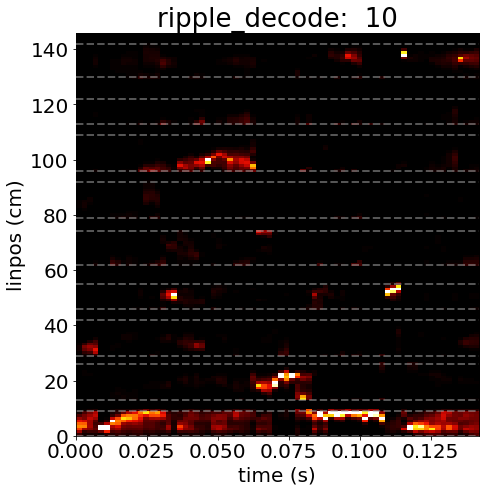

In [16]:
%%opts Image {+axiswise} [height=300 width=300 aspect=1]
%%opts Curve.arm_bound {+axiswise} [aspect=1] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=1] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=200

dec_viz.plot_ripple_all(10)

In [17]:
#list of ripples, missing last ripple
np.unique(posteriors.ripple_grp)[2:-1]

posteriors1 = posteriors.reset_index()
rip_post = posteriors1.query('ripple_grp == 2').get_distribution_view()
#rip_time = rip_post.index.get_level_values('time')
#rip_img = hv.Image(np.flip(rip_post.values.T, axis=0),
#                    bounds=(0, encode_settings.pos_bins[0],
#                            rip_time[-1]-rip_time[0], encode_settings.pos_bins[-1]),
#                           kdims=[time_dim_name, pos_dim_name], vdims=[val_dim_name],
#                           label='ripple_decode: ', group=str(2))

#rip_img = rip_img.redim(probability={'range': (0, 0.3)})
rip_post
posteriors1
#posteriors
#rip_post.index.shape
#posteriors has time bin of 2 msec, so we want ripple_grp +100 and -100 bins

,day,epoch,timestamp,time,x000,x001,x002,...,x143,x144,x145,x146,num_spikes,dec_bin,ripple_grp
0,20,2,40832220,1361.074,9.4732e-03,9.4467e-03,8.4975e-03,...,0.0,0.0,0.0,0.0,1.0,0.0,-1
1,20,2,40832280,1361.076,1.0007e-06,5.5078e-06,3.6450e-05,...,0.0,0.0,0.0,0.0,4.0,1.0,-1
2,20,2,40832340,1361.078,8.6581e-05,9.8169e-04,7.4439e-03,...,0.0,0.0,0.0,0.0,3.0,2.0,-1
3,20,2,40832400,1361.080,4.8987e-04,2.9558e-03,7.8885e-03,...,0.0,0.0,0.0,0.0,0.0,3.0,-1
4,20,2,40832460,1361.082,8.2415e-04,2.5689e-03,8.2485e-03,...,0.0,0.0,0.0,0.0,2.0,4.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168361,20,2,50933880,1697.796,1.4412e-03,2.4274e-03,4.2838e-03,...,0.0,0.0,0.0,0.0,1.0,168361.0,-1
168362,20,2,50933940,1697.798,1.9193e-03,2.8808e-03,4.3524e-03,...,0.0,0.0,0.0,0.0,0.0,168362.0,-1
168363,20,2,50934000,1697.800,1.5220e-03,2.1271e-03,3.4919e-03,...,0.0,0.0,0.0,0.0,1.0,168363.0,-1
168364,20,2,50934060,1697.802,1.8527e-03,2.5102e-03,3.7150e-03,...,0.0,0.0,0.0,0.0,0.0,168364.0,-1


In [81]:
occupancy

NameError: name 'occupancy' is not defined

In [ ]:
%%opts Image {+axiswise} [height=300 width=300 aspect=1]
%%opts Curve {+axiswise} [aspect=1] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=1] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=200

dec_viz = DecodeVisualizer(posteriors, linpos=linflat_obj, riptimes=ripdata.get_above_maxthresh(5), enc_settings=encode_settings)

rip_plots = dec_viz.plot_ripple_grid(2)
for plt_grp in rip_plots:
    display(plt_grp)

In [ ]:
%%output size=300
dec_viz.plot_ripple_all(242)

In [ ]:
np.append(plt_range_high, [270])